In [11]:
import pickle 
from pathlib import Path 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# load precalculated embeddings

In [12]:
DATA_DIR = Path().absolute().parent / 'data'

with open(DATA_DIR / 'embeddings.pickle', 'rb') as f:
    embeddings_deepface = pickle.load(f)

with open(DATA_DIR / 'embeddings_insightface_v2_128x128.pickle', 'rb') as f:
    embeddings_insightface = pickle.load(f)

embeddings = embeddings_deepface | embeddings_insightface
print(embeddings.keys())

dict_keys(['VGG-Face', 'OpenFace', 'Facenet', 'Facenet512', 'DeepFace', 'DeepID', 'Dlib', 'ArcFace', 'SFace', 'buffalo_s', 'buffalo_sc', 'buffalo_m', 'buffalo_l', 'antelopev2'])


In [13]:
def dict2df(model_dict):
    embeddings = []
    labels = []
    is_fake = []
    fnames = []
    for label, embedding in model_dict.items():
        for fname, emb in embedding.items():
            if label == "ck":
                is_fake.append(1)
                labels.append(fname.split(".")[0])
            else:
                is_fake.append(0)
                labels.append(label)
            embeddings.append(np.array(emb["embedding"]))
            fnames.append(fname)
    df = pd.DataFrame({
    "embeddings": embeddings, 
    "labels": labels,
    "fnames": fnames,
    "is_fake": is_fake
    })
    return df

model2df = {model: dict2df(model_dict) for model, model_dict in embeddings.items()}
model2df["Facenet"].head()

embeddings    labels  \
0  [-1.4944489002227783, -1.4114049673080444, -0....  dr_house   
1  [-1.9788538217544556, -1.7696497440338135, -0....  dr_house   
2  [-2.5532069206237793, -0.7926962375640869, -0....  dr_house   
3  [-1.2020866870880127, -1.5620497465133667, -0....  dr_house   
4  [-3.0435636043548584, -2.2254717350006104, -0....  dr_house   

             fnames  is_fake  
0  008_ecae6a22.jpg        0  
1  002_3299cc32.jpg        0  
2  004_00999bba.jpg        0  
3  003_e525969e.jpg        0  
4  009_25abfef1.jpg        0

VGG-Face
(117, 2622)
(117, 117)


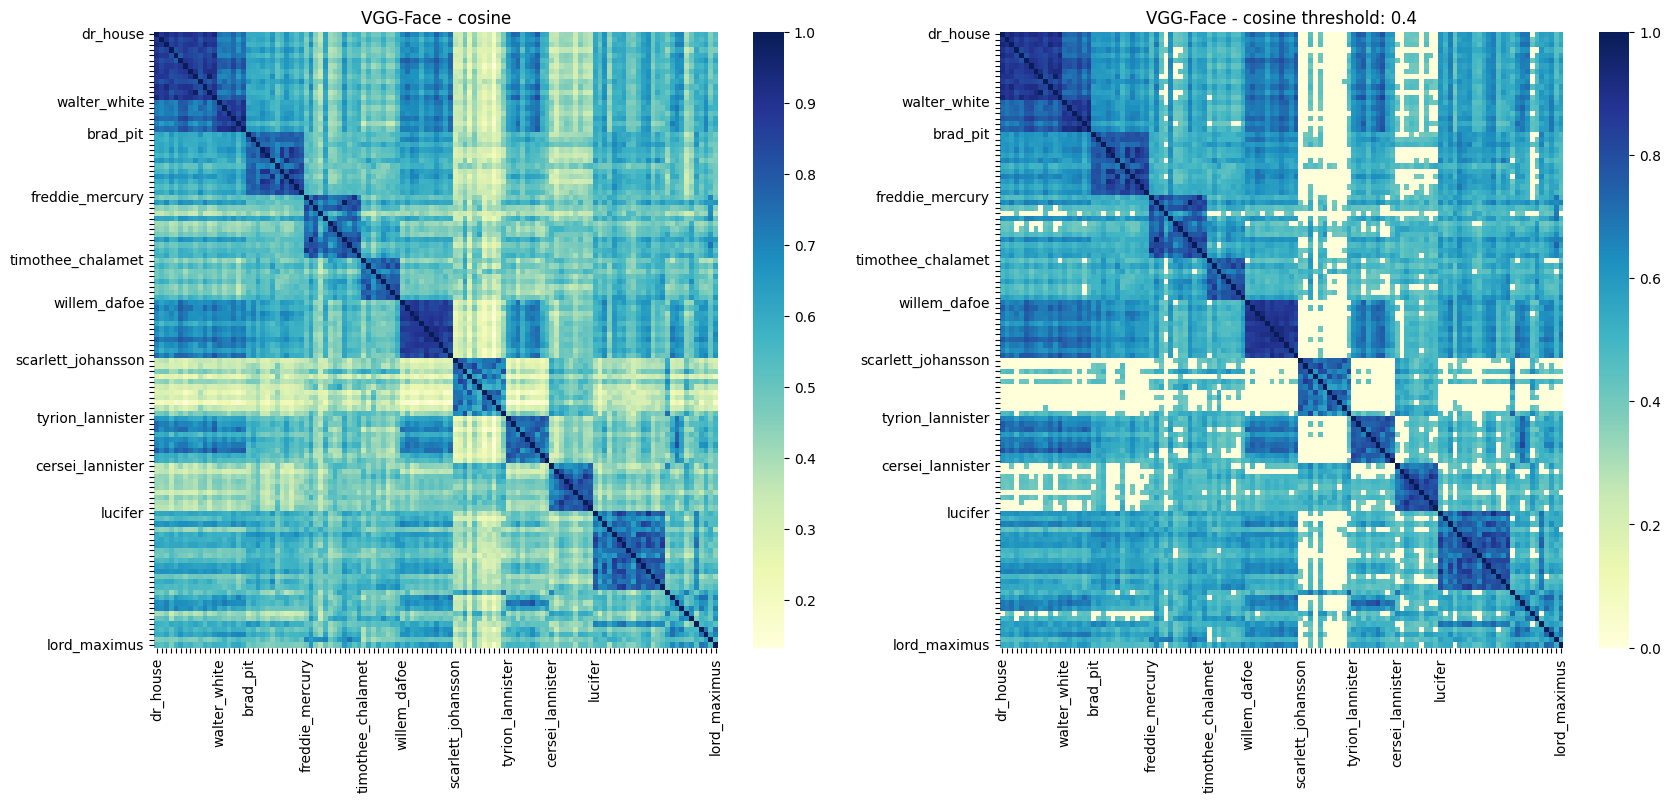

(117, 117)


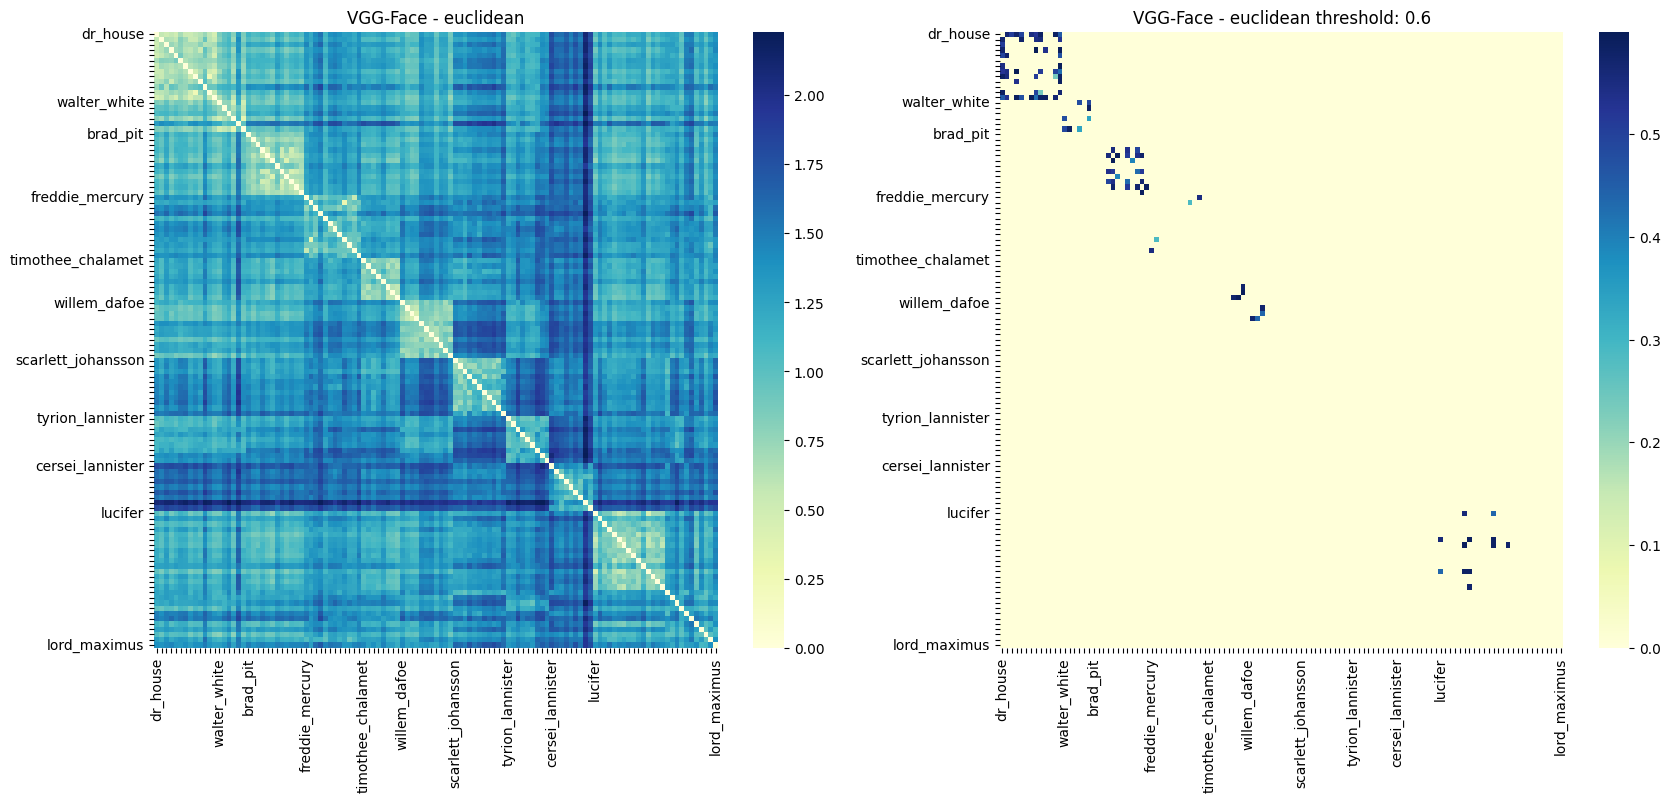

OpenFace
(117, 128)
(117, 117)


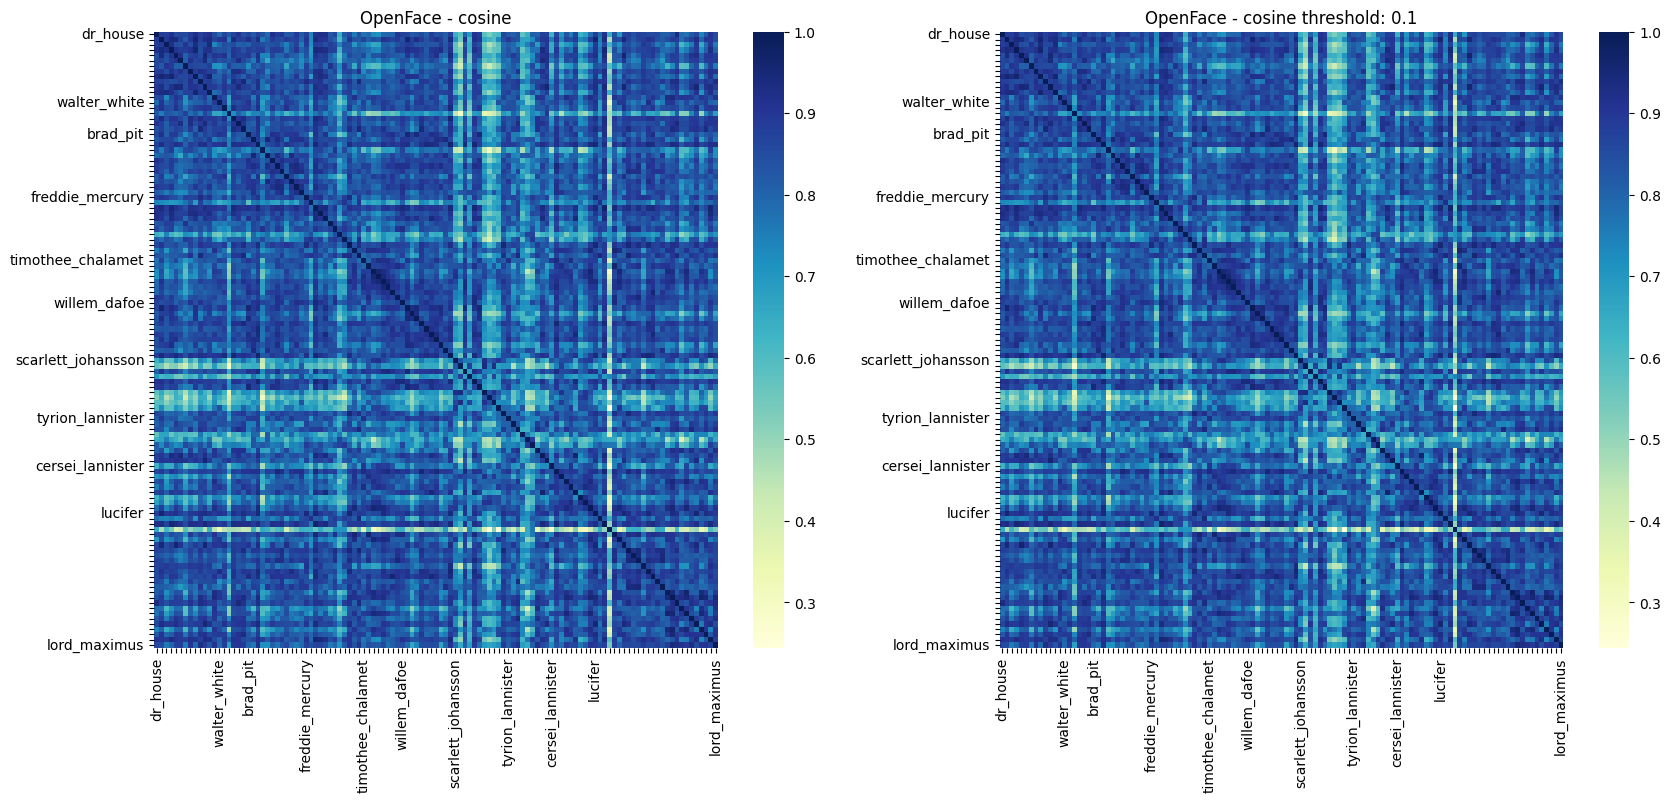

(117, 117)


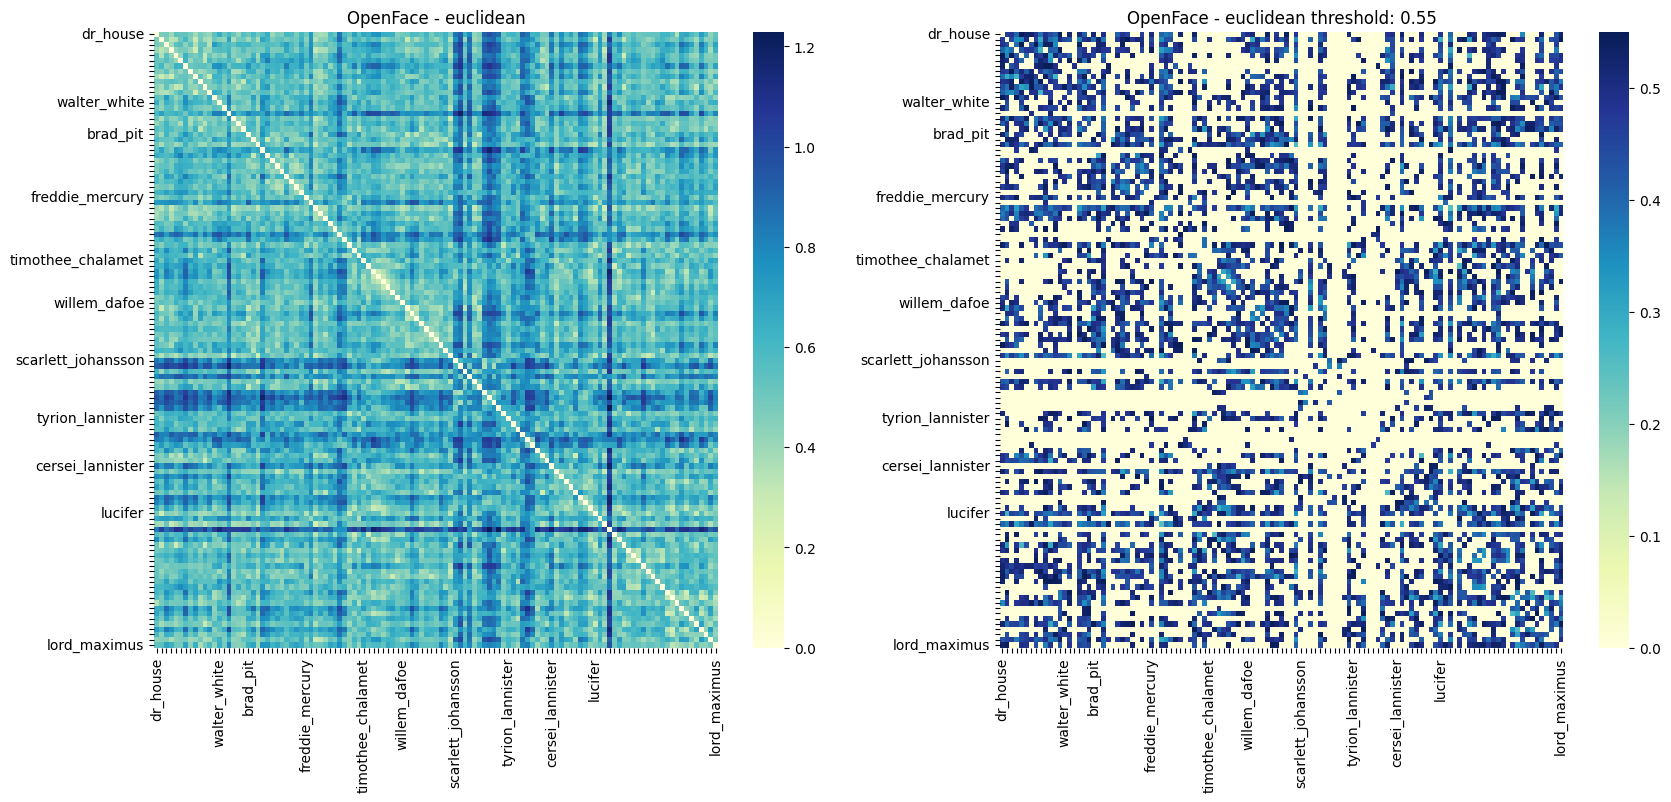

Facenet
(117, 128)
(117, 117)


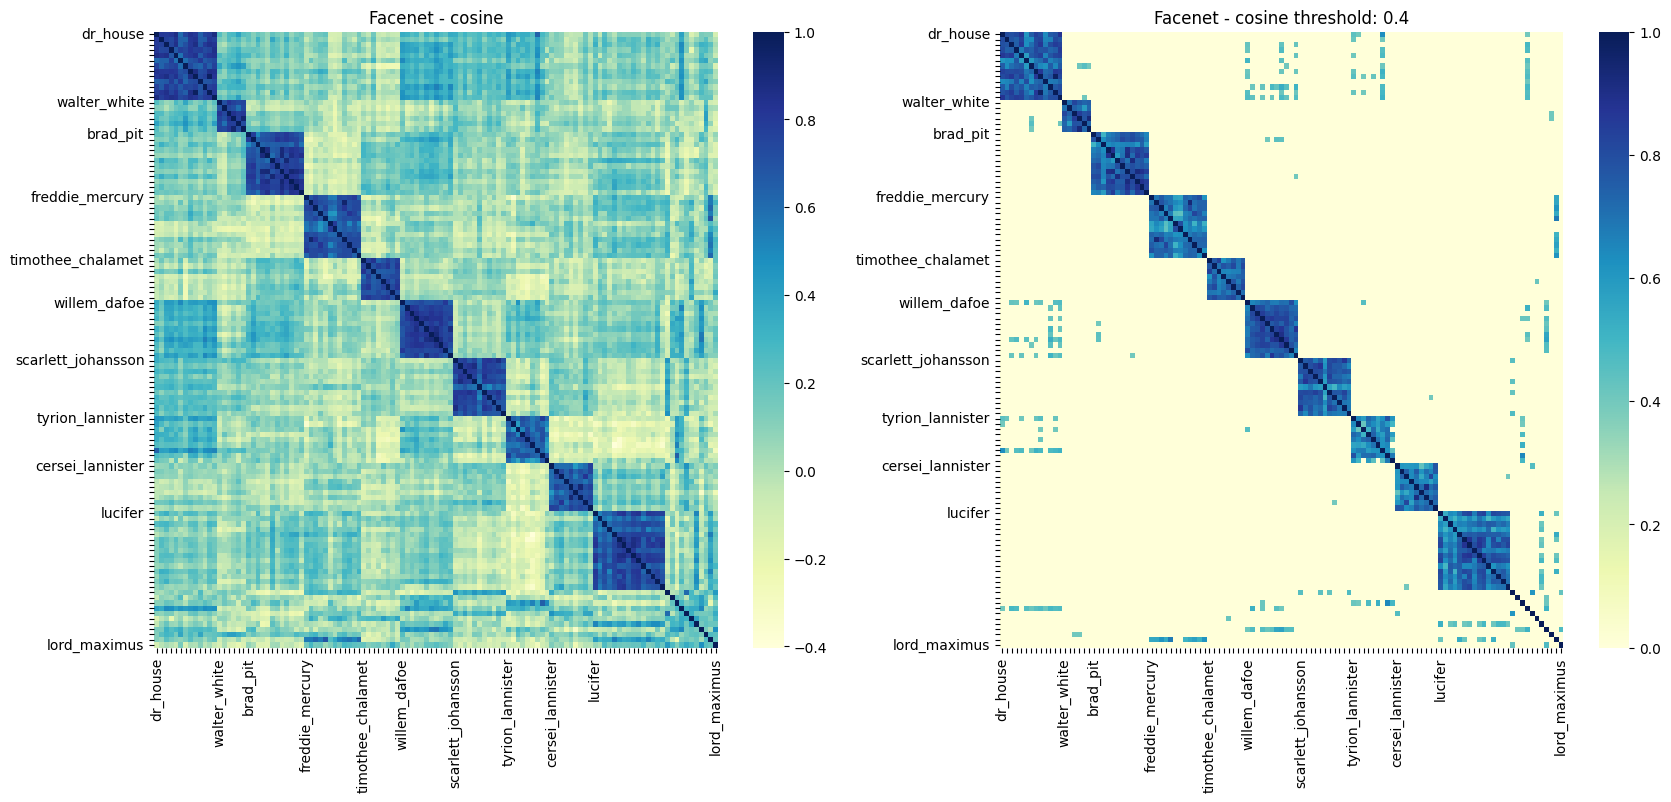

(117, 117)


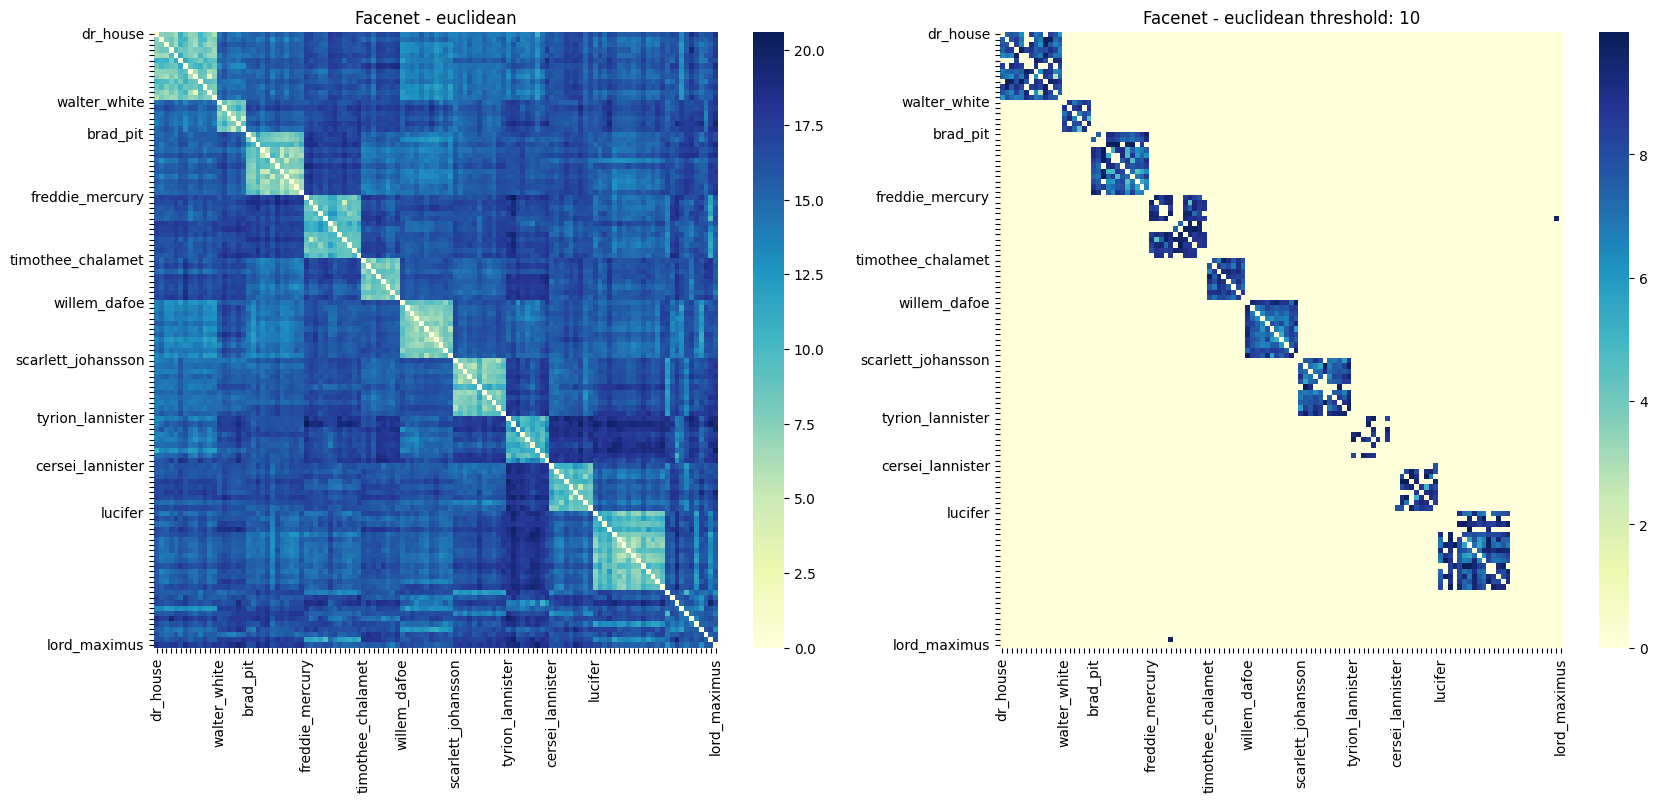

Facenet512
(117, 512)
(117, 117)


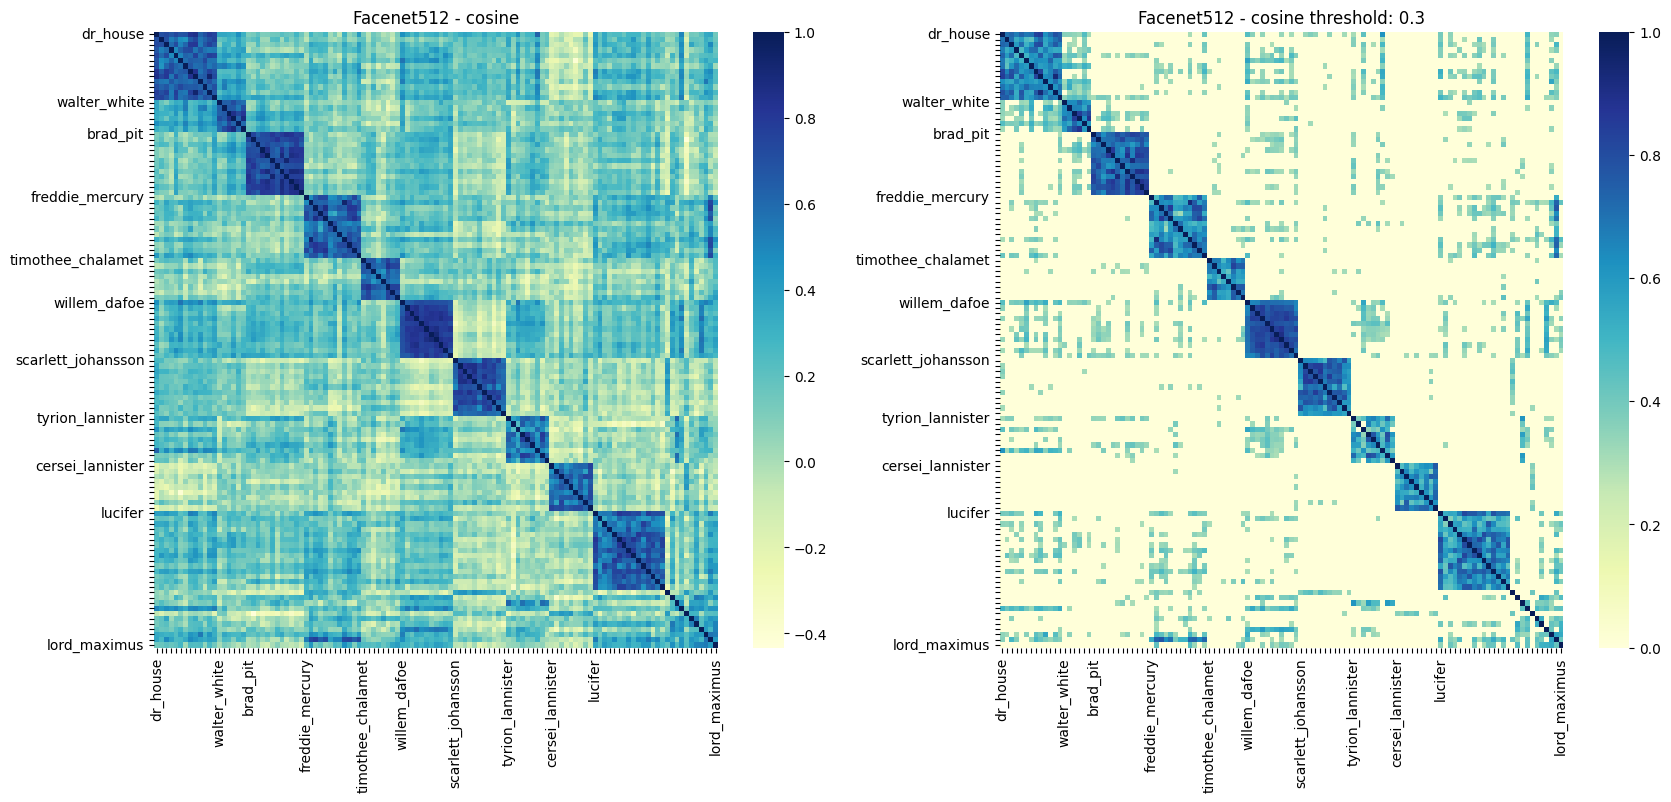

(117, 117)


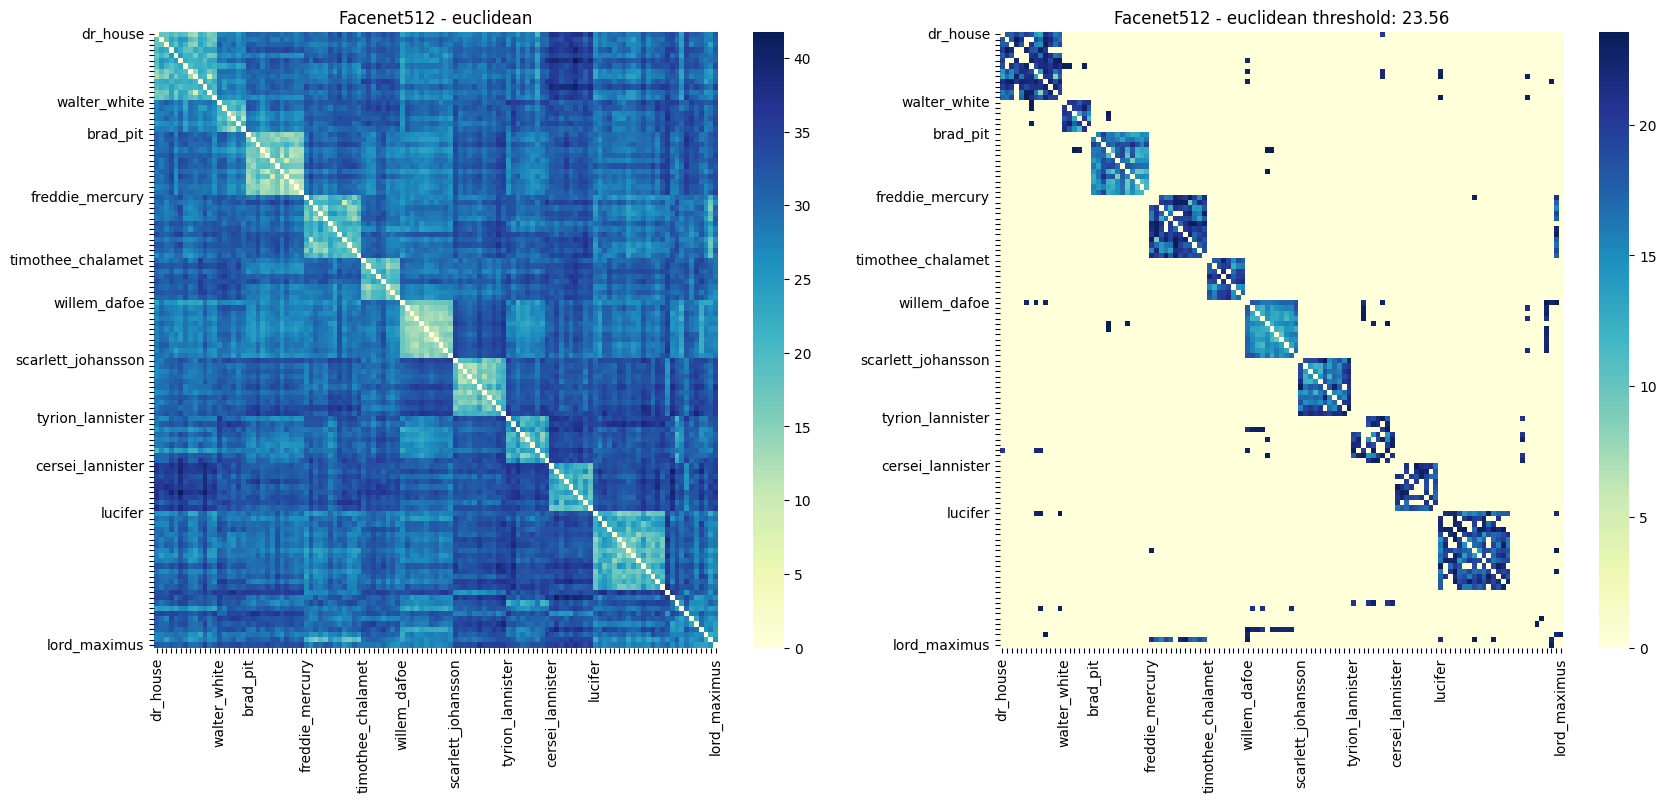

DeepFace
(117, 4096)
(117, 117)


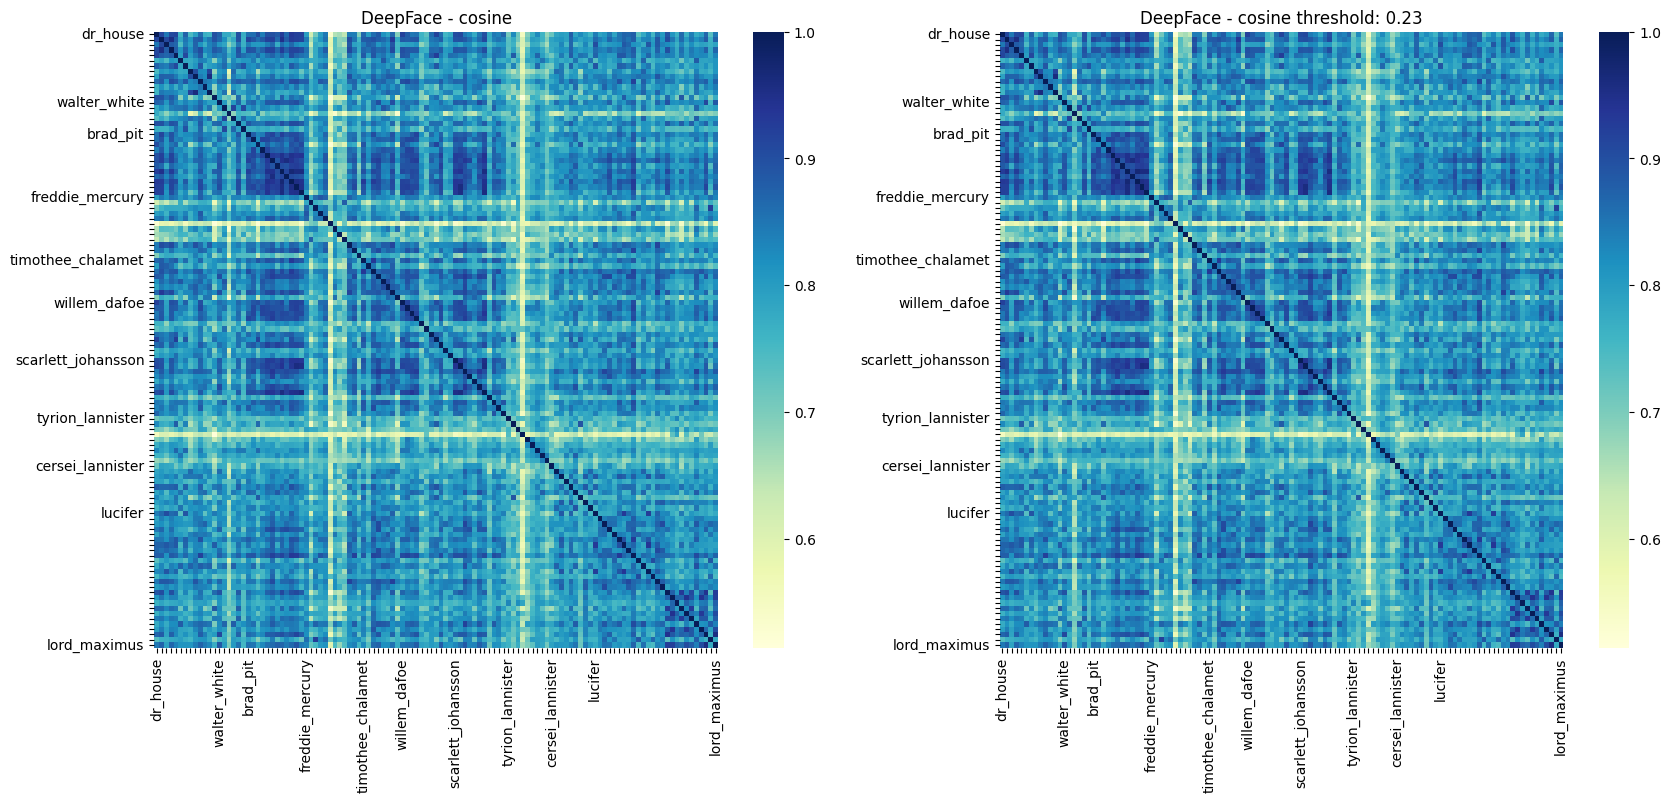

(117, 117)


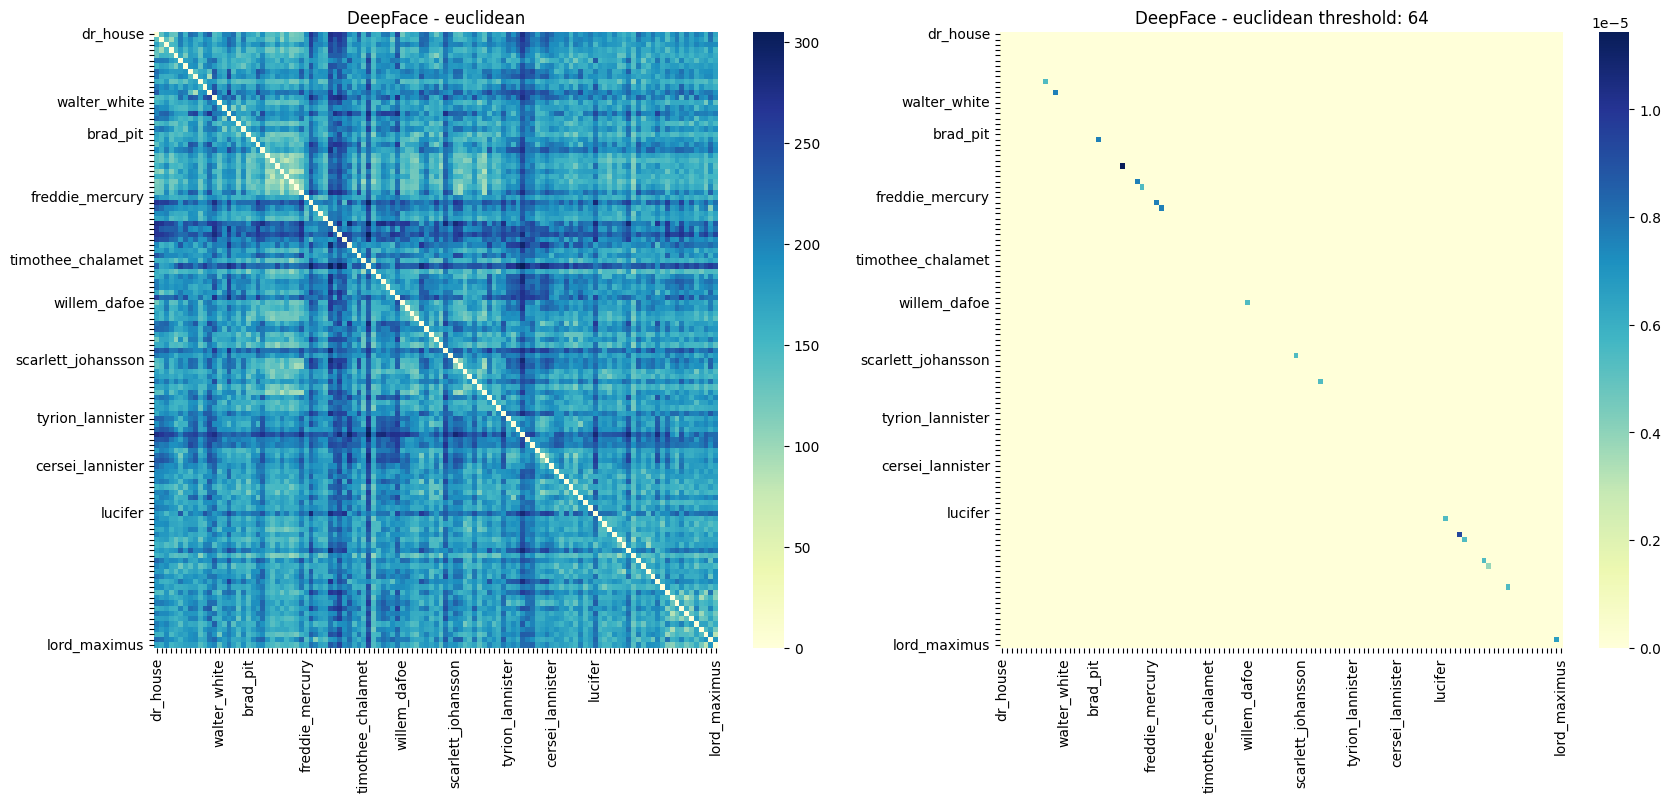

DeepID
(117, 160)
(117, 117)


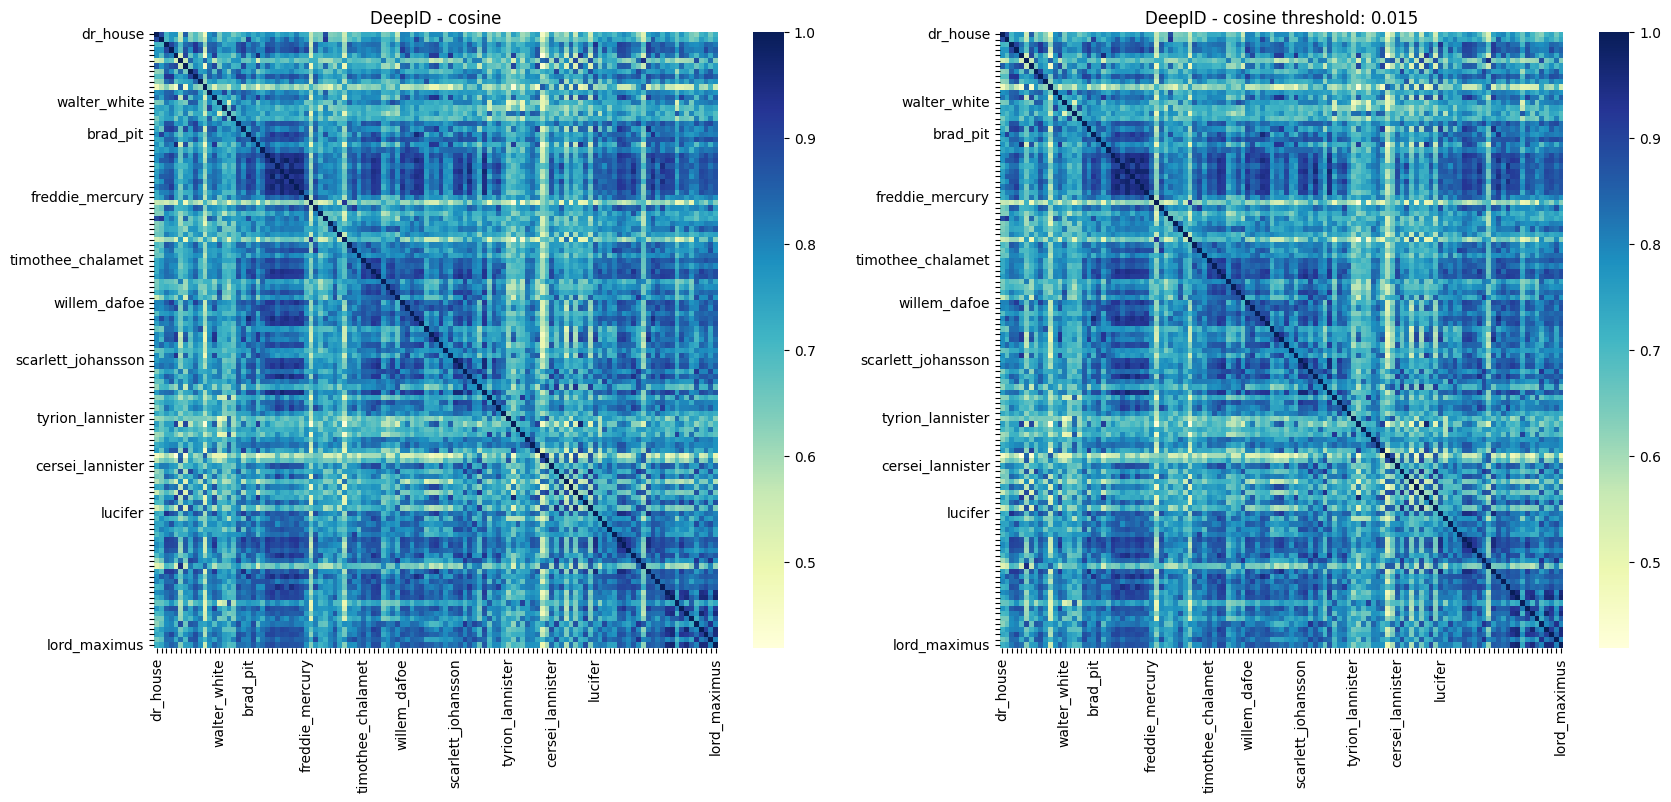

(117, 117)


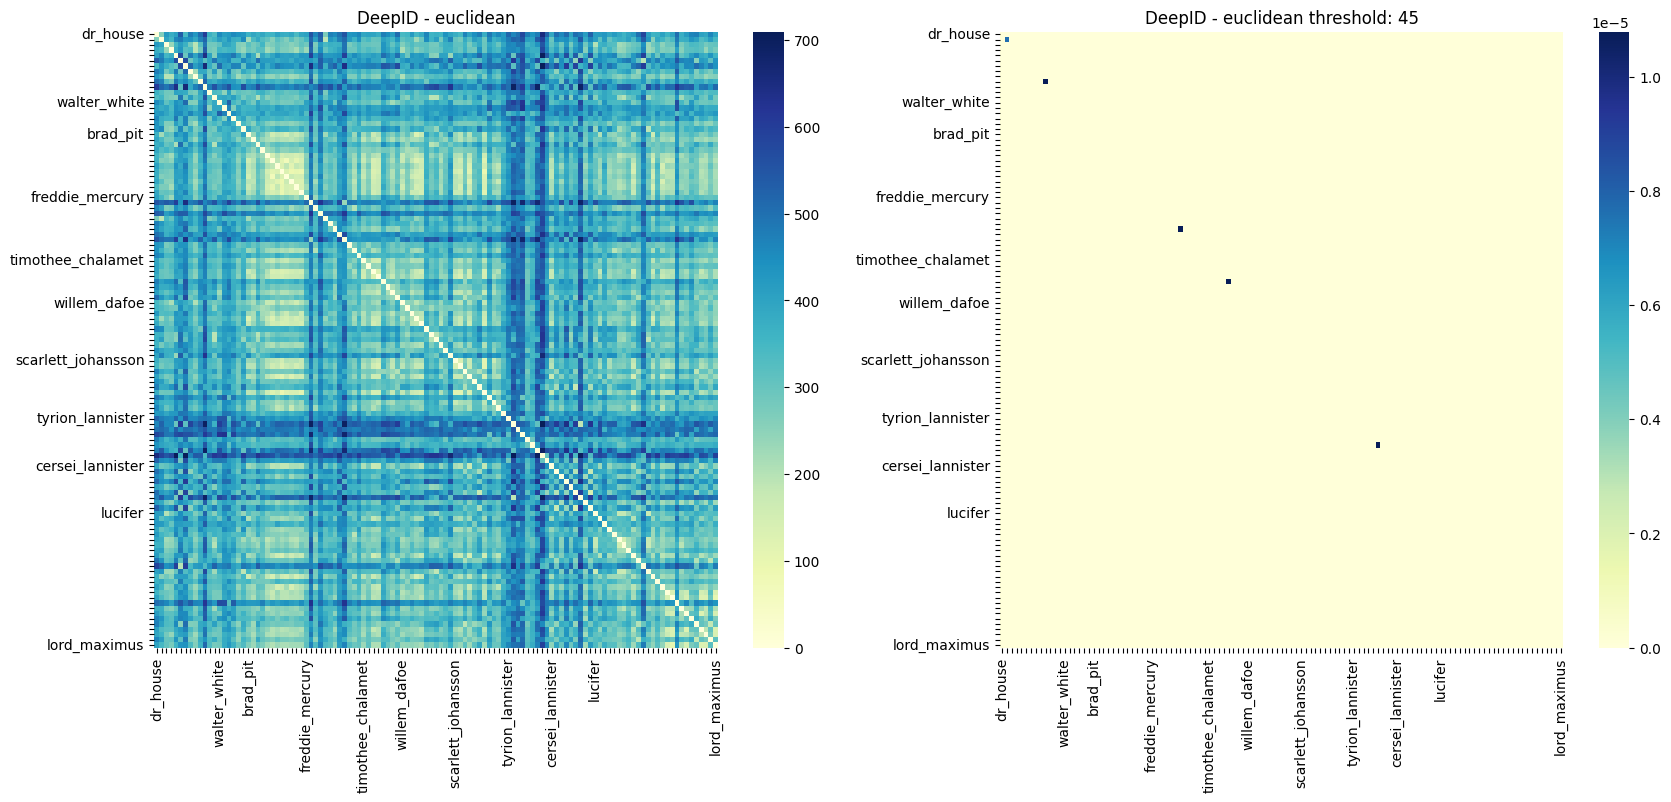

Dlib
(117, 128)
(117, 117)


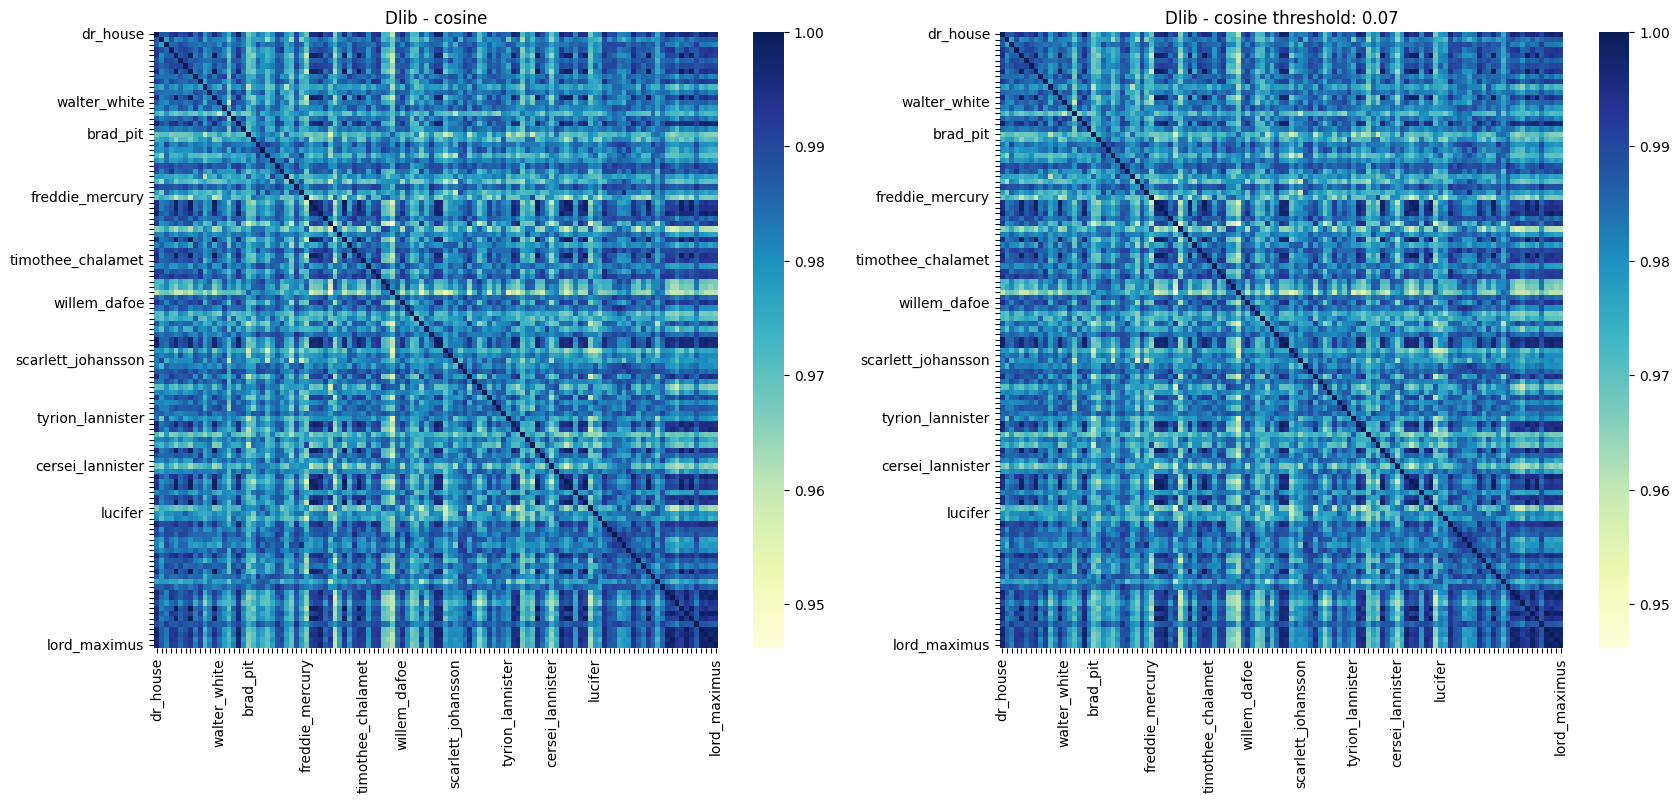

(117, 117)


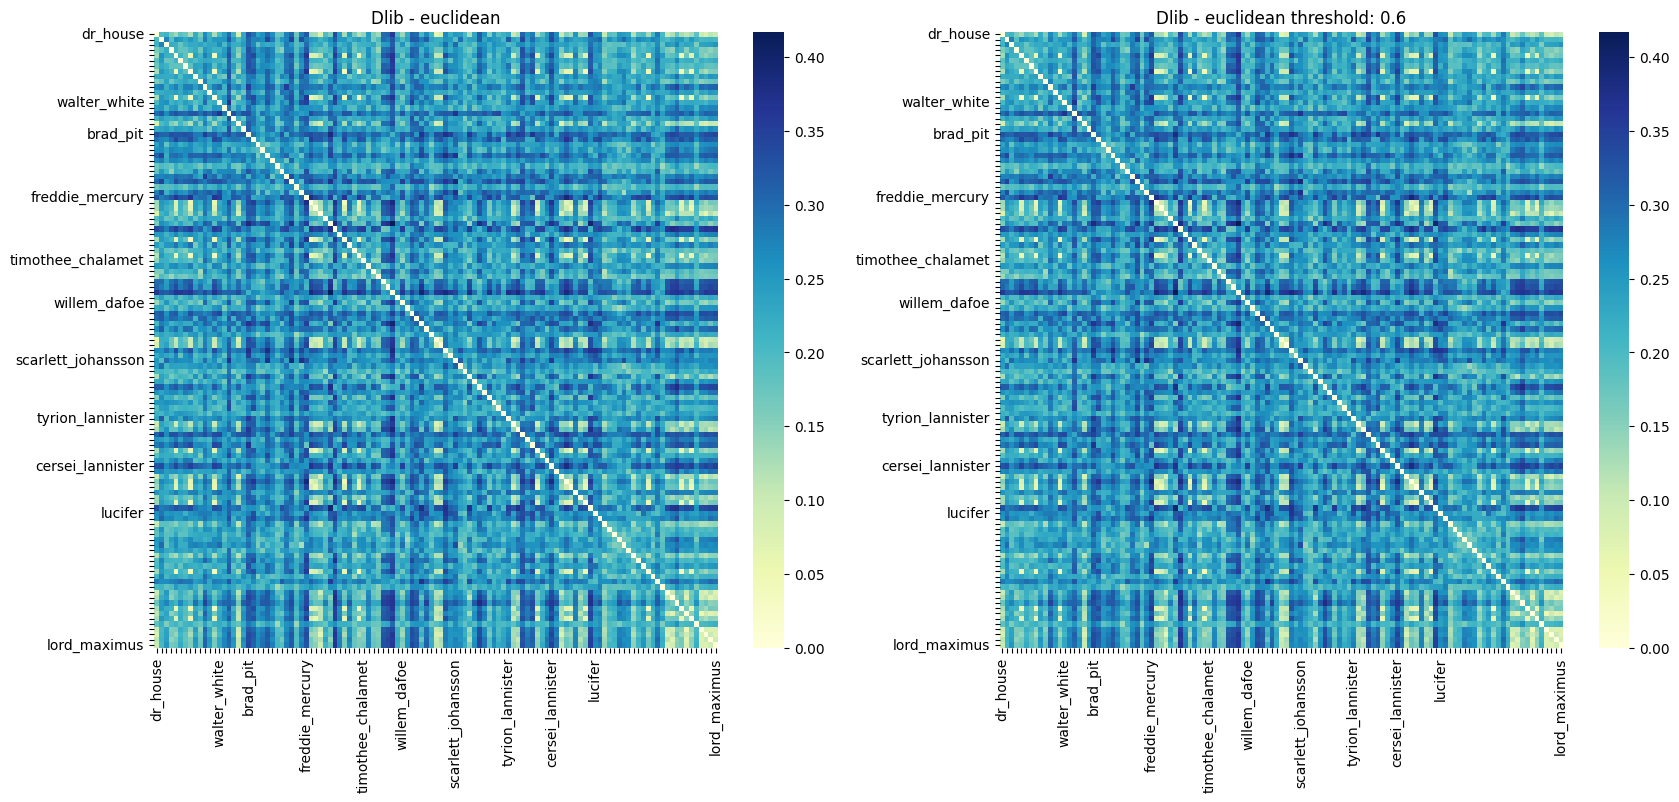

ArcFace
(117, 512)
(117, 117)


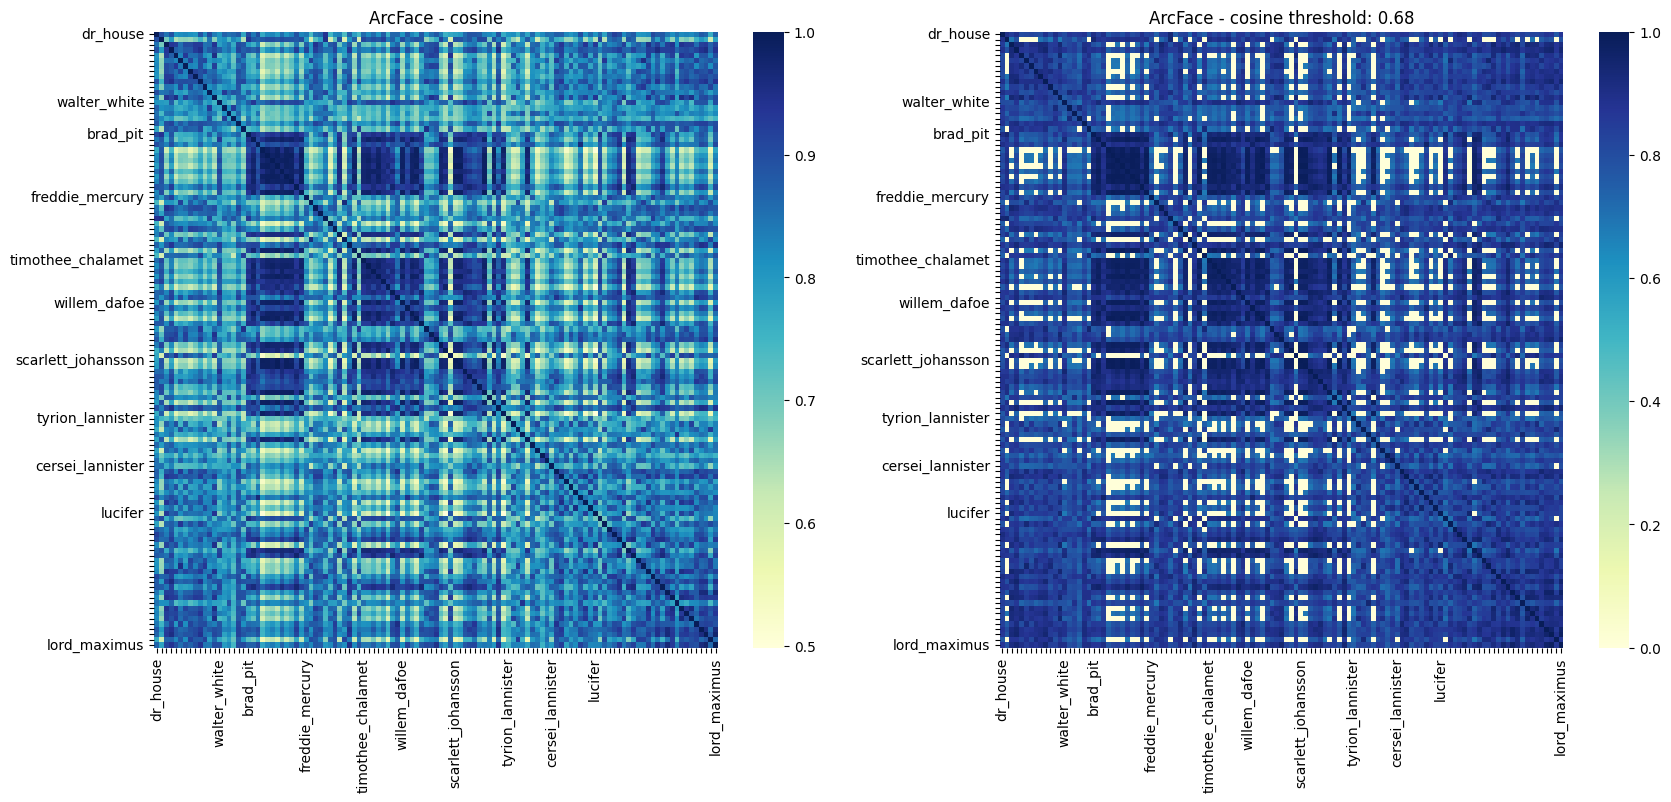

(117, 117)


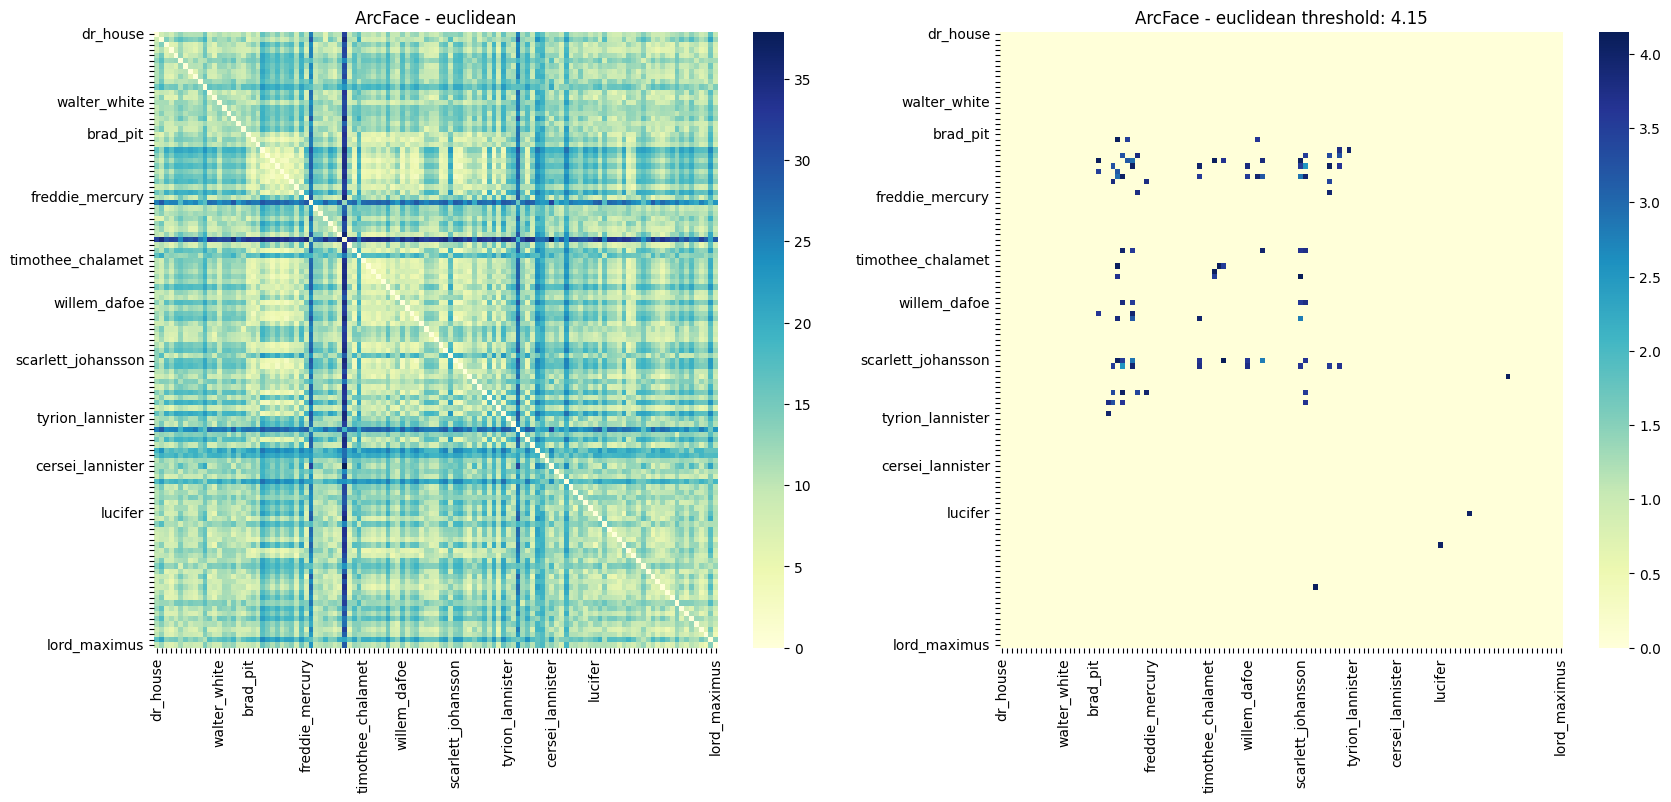

SFace
(117, 128)
(117, 117)


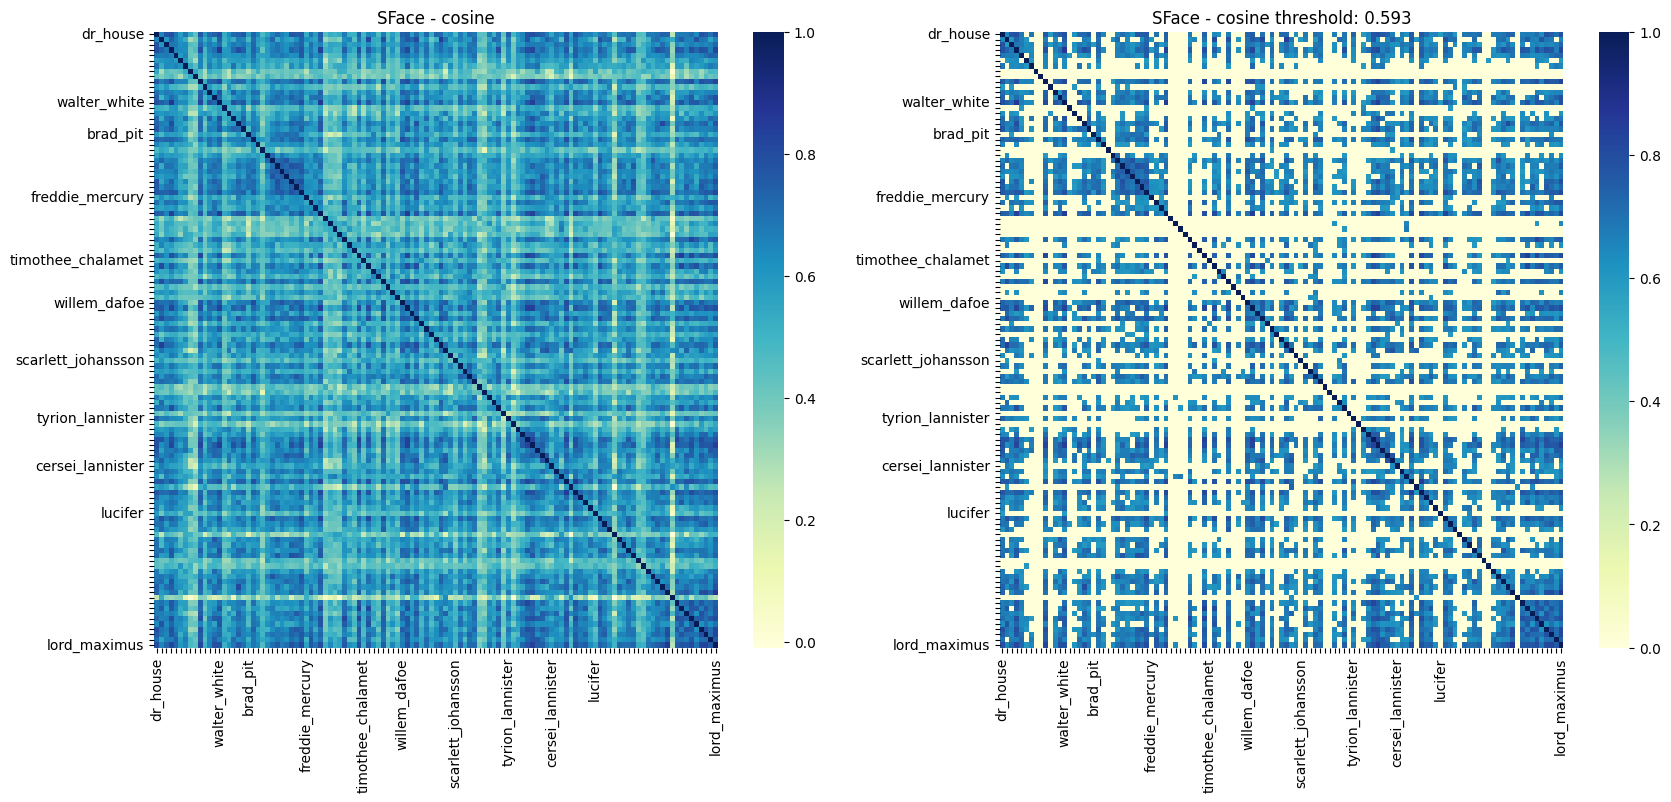

(117, 117)


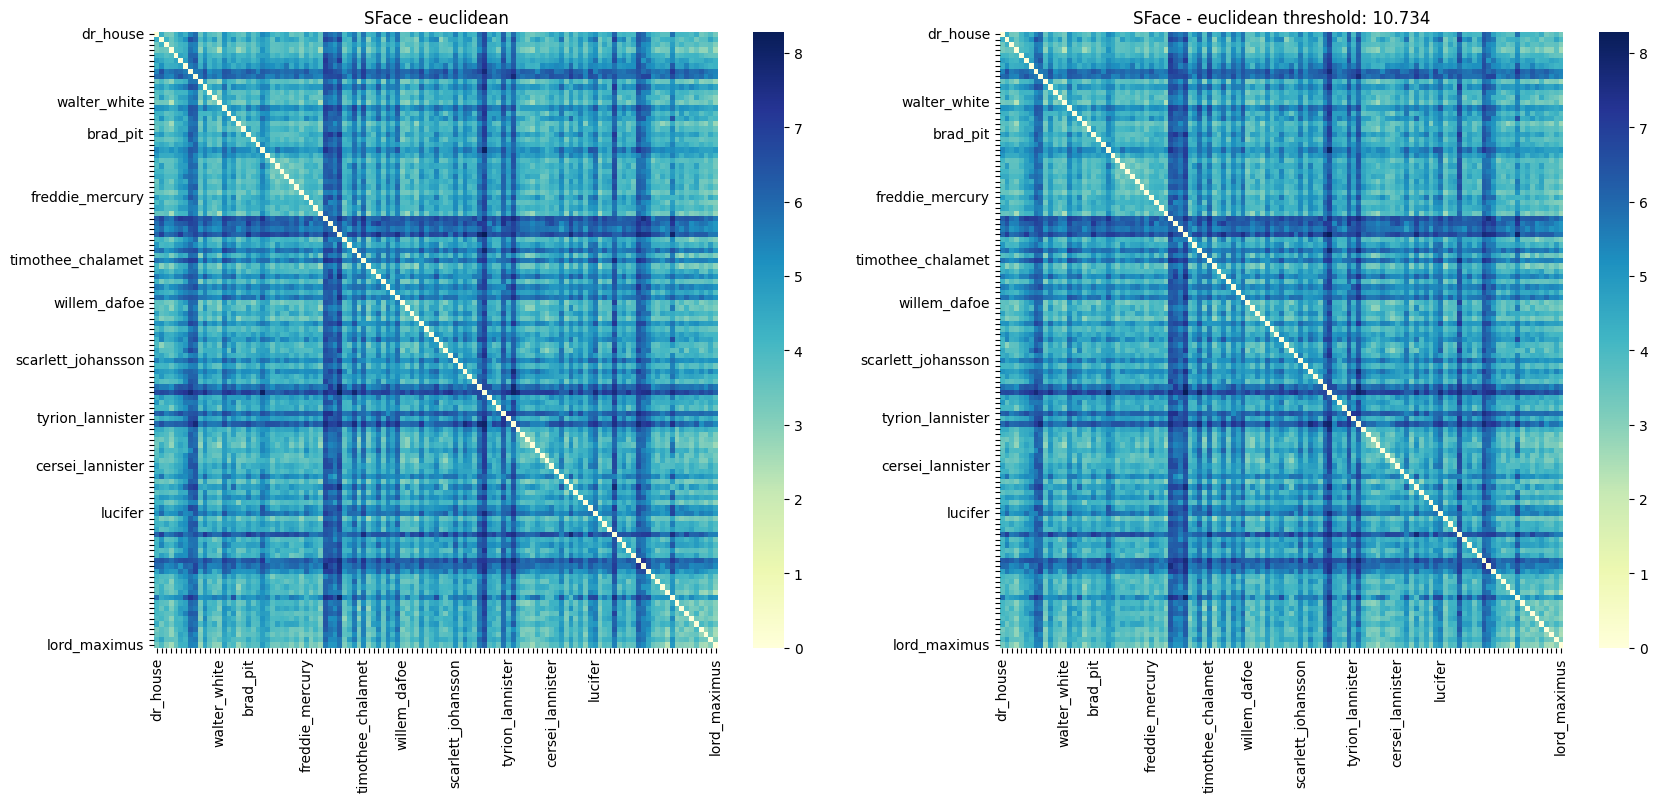

buffalo_s
(117, 512)
(117, 117)


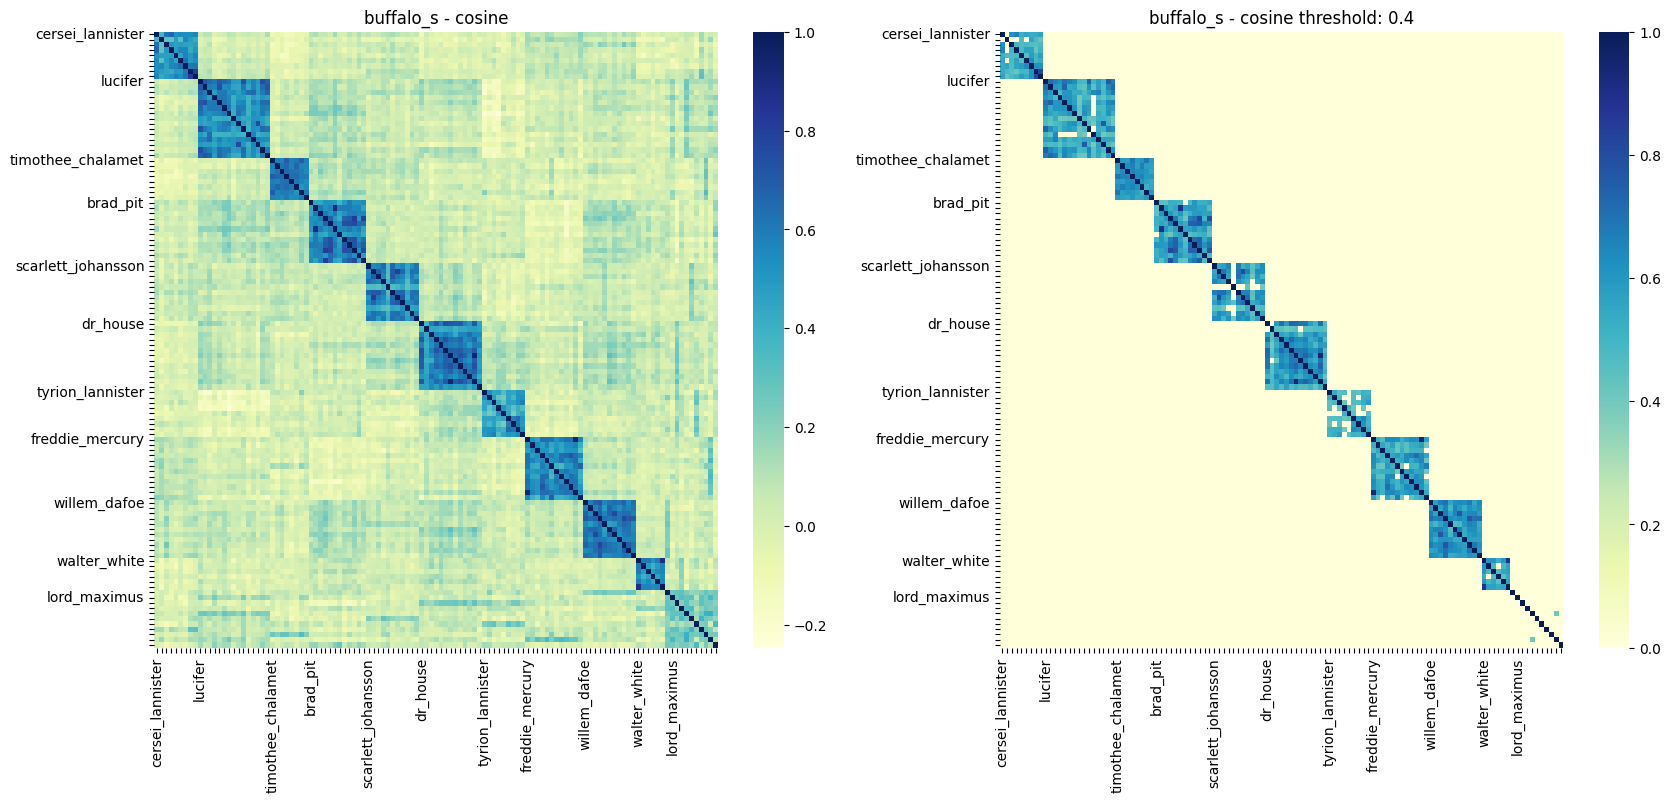

(117, 117)


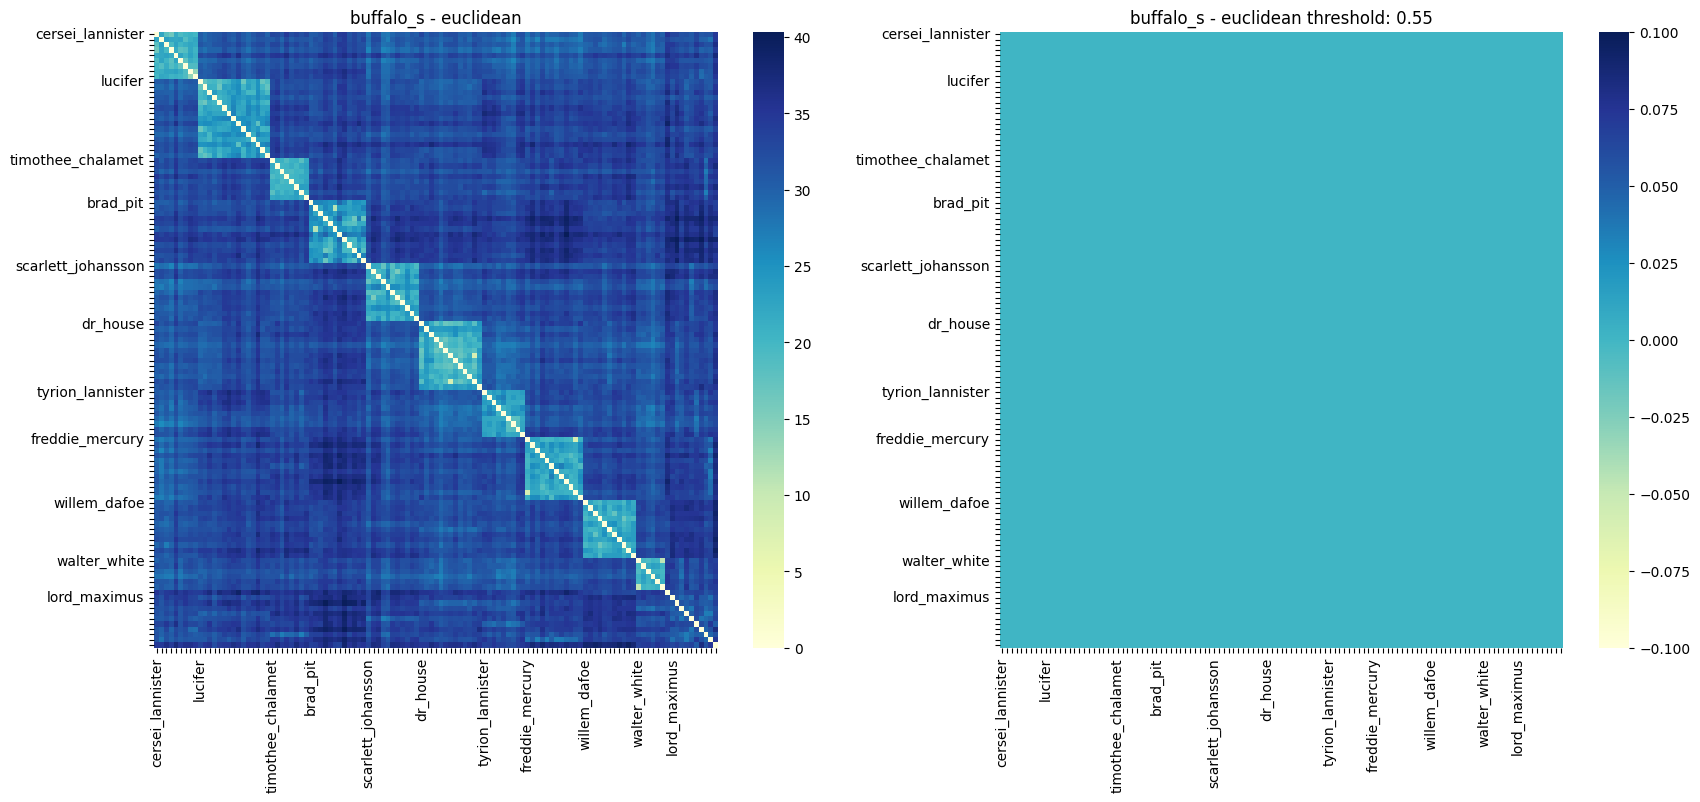

buffalo_sc
(117, 512)
(117, 117)


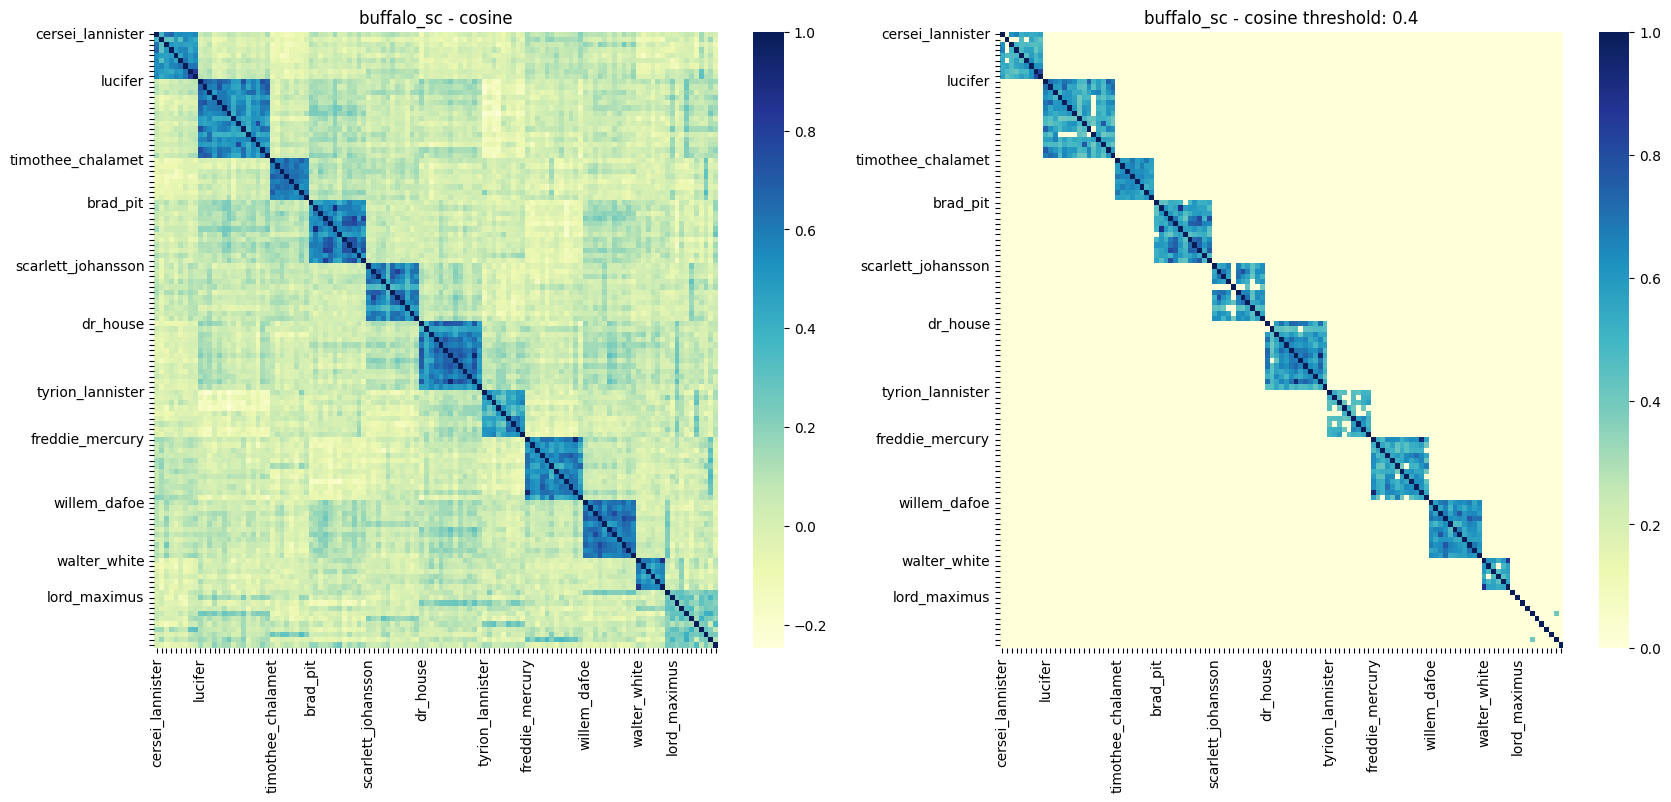

(117, 117)


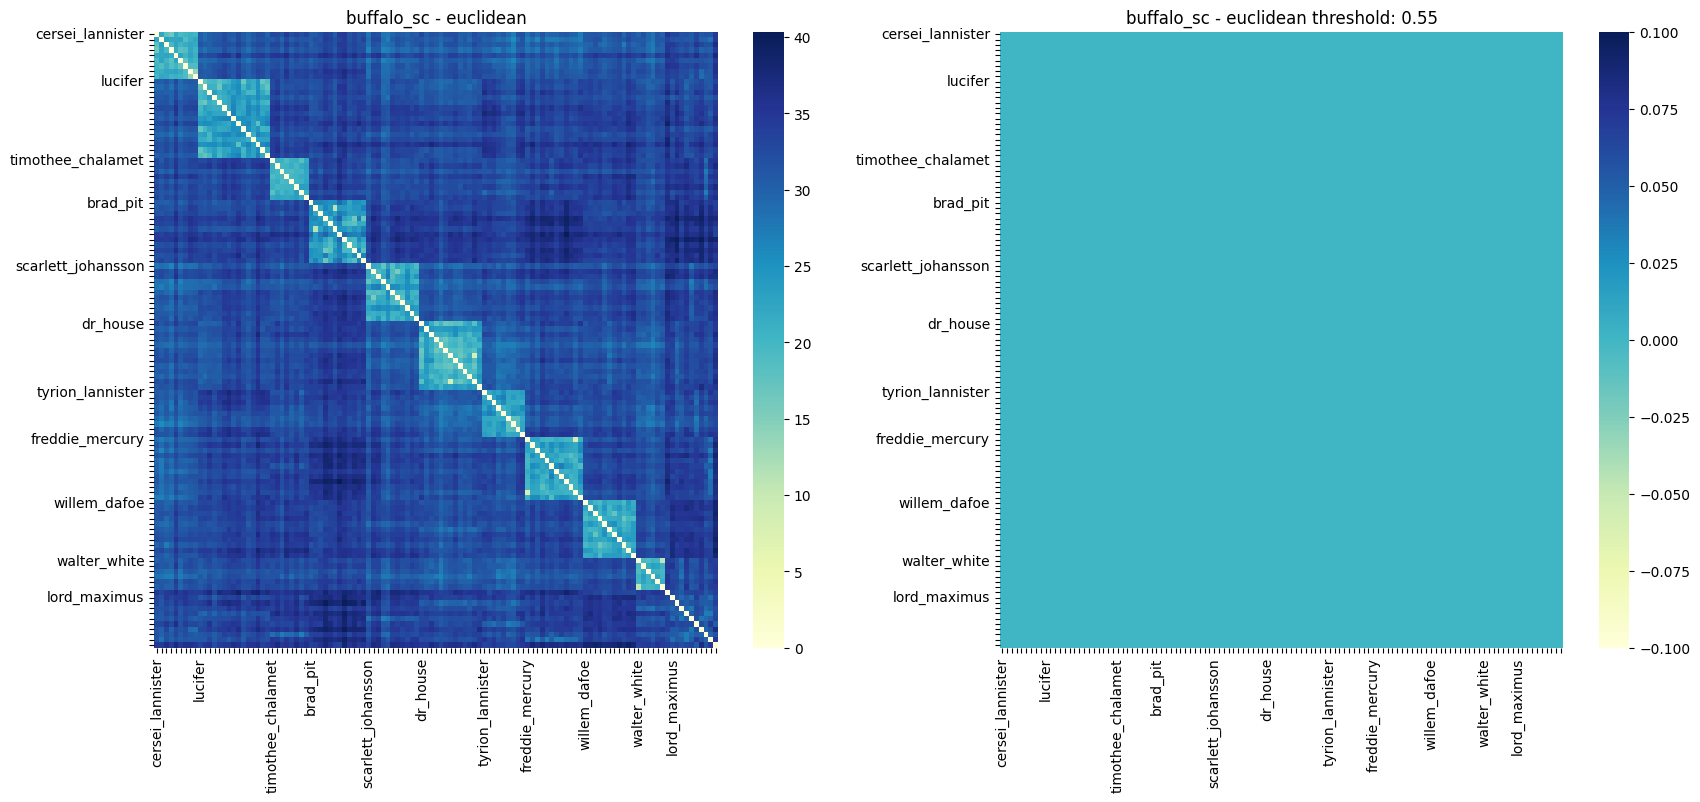

buffalo_m
(117, 512)
(117, 117)


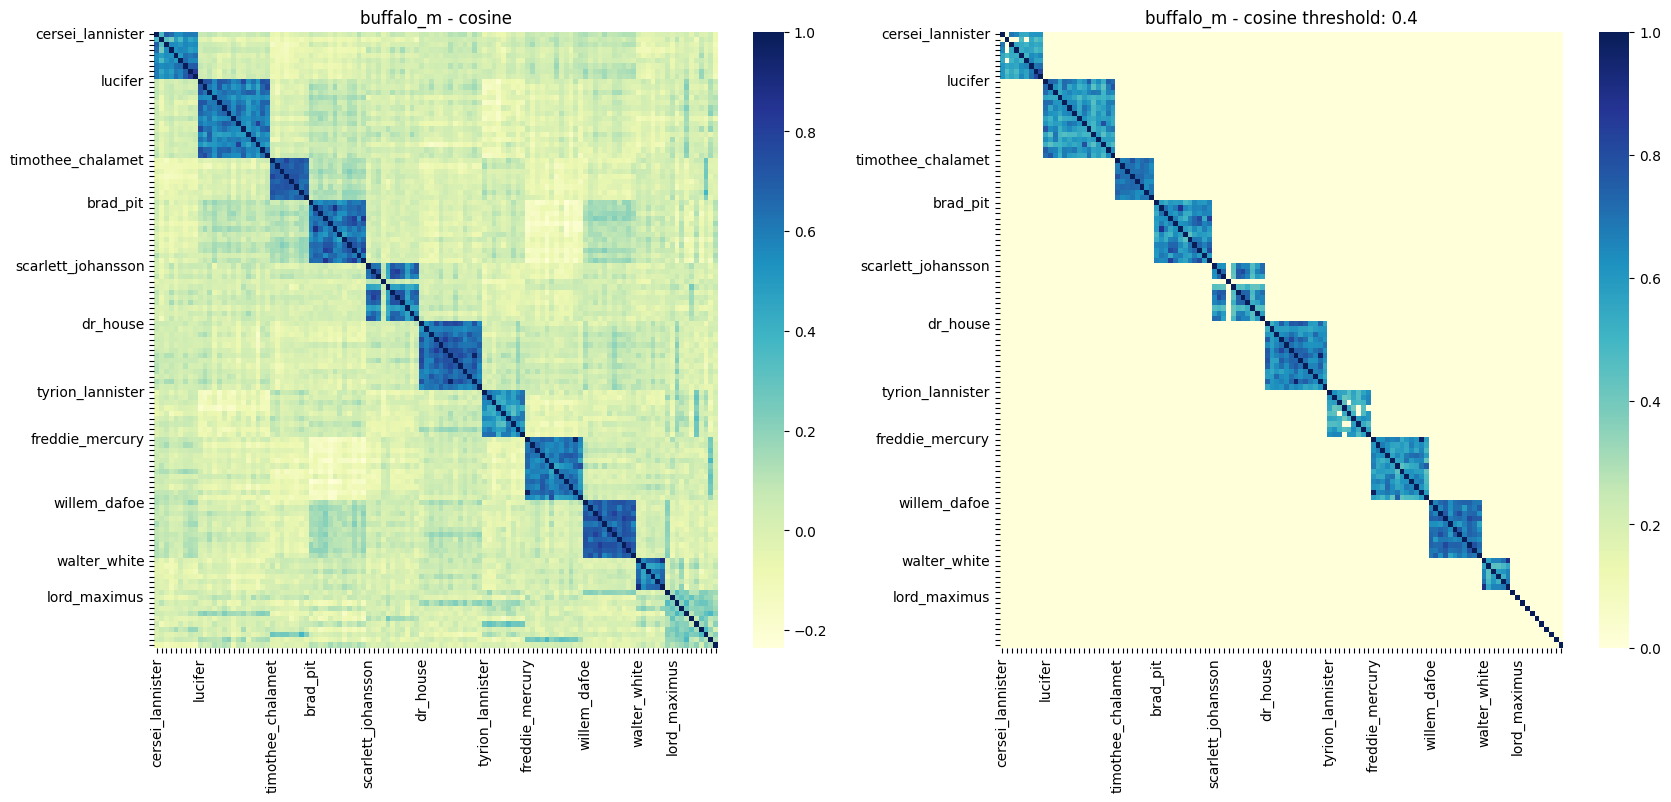

(117, 117)


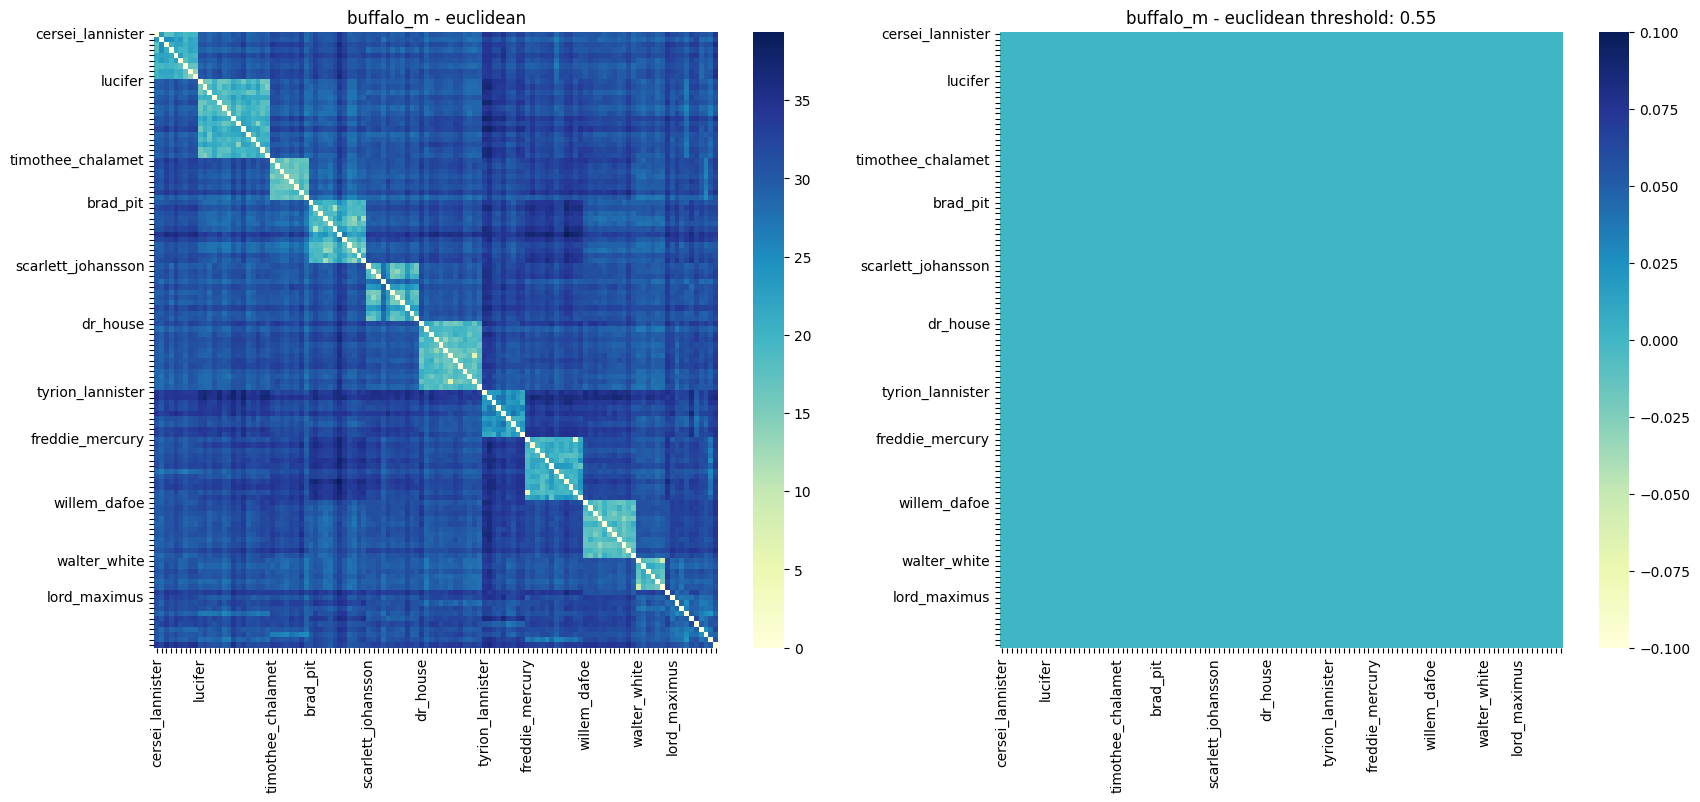

buffalo_l
(117, 512)
(117, 117)


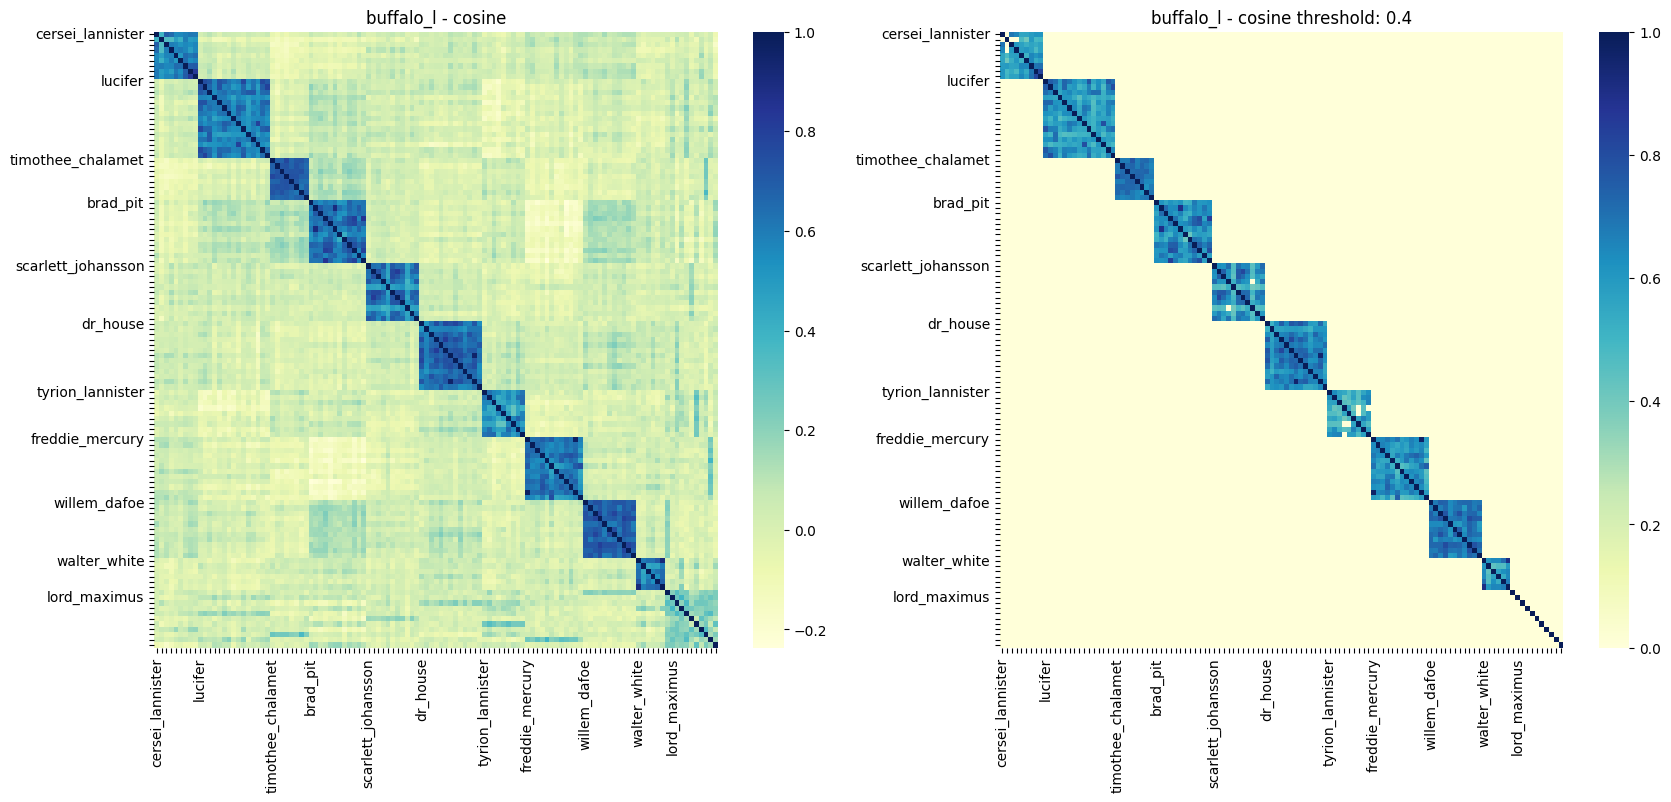

(117, 117)


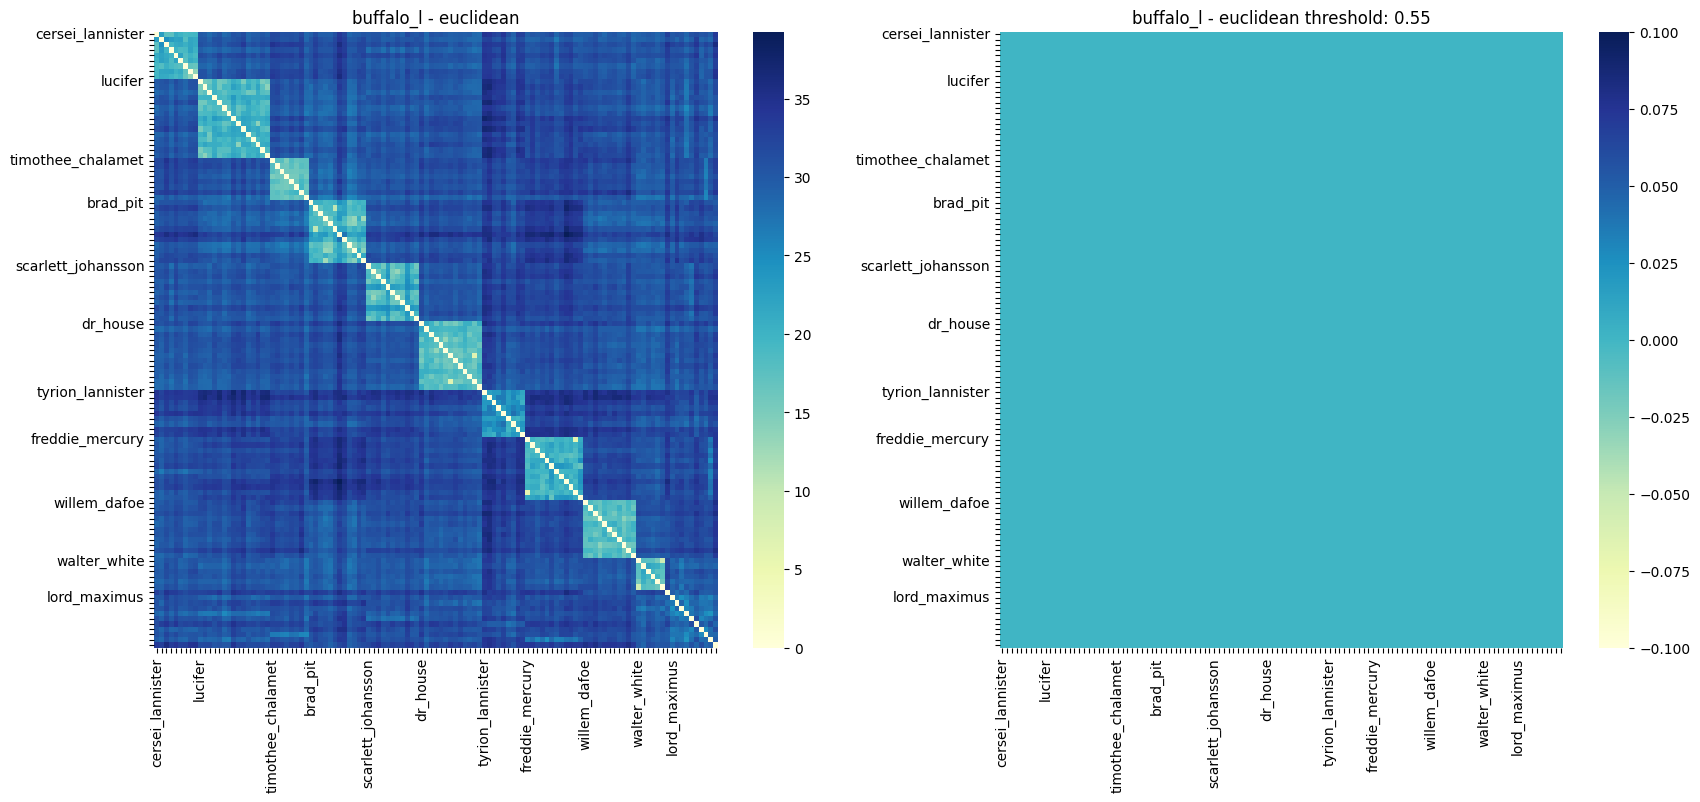

antelopev2
(117, 512)
(117, 117)


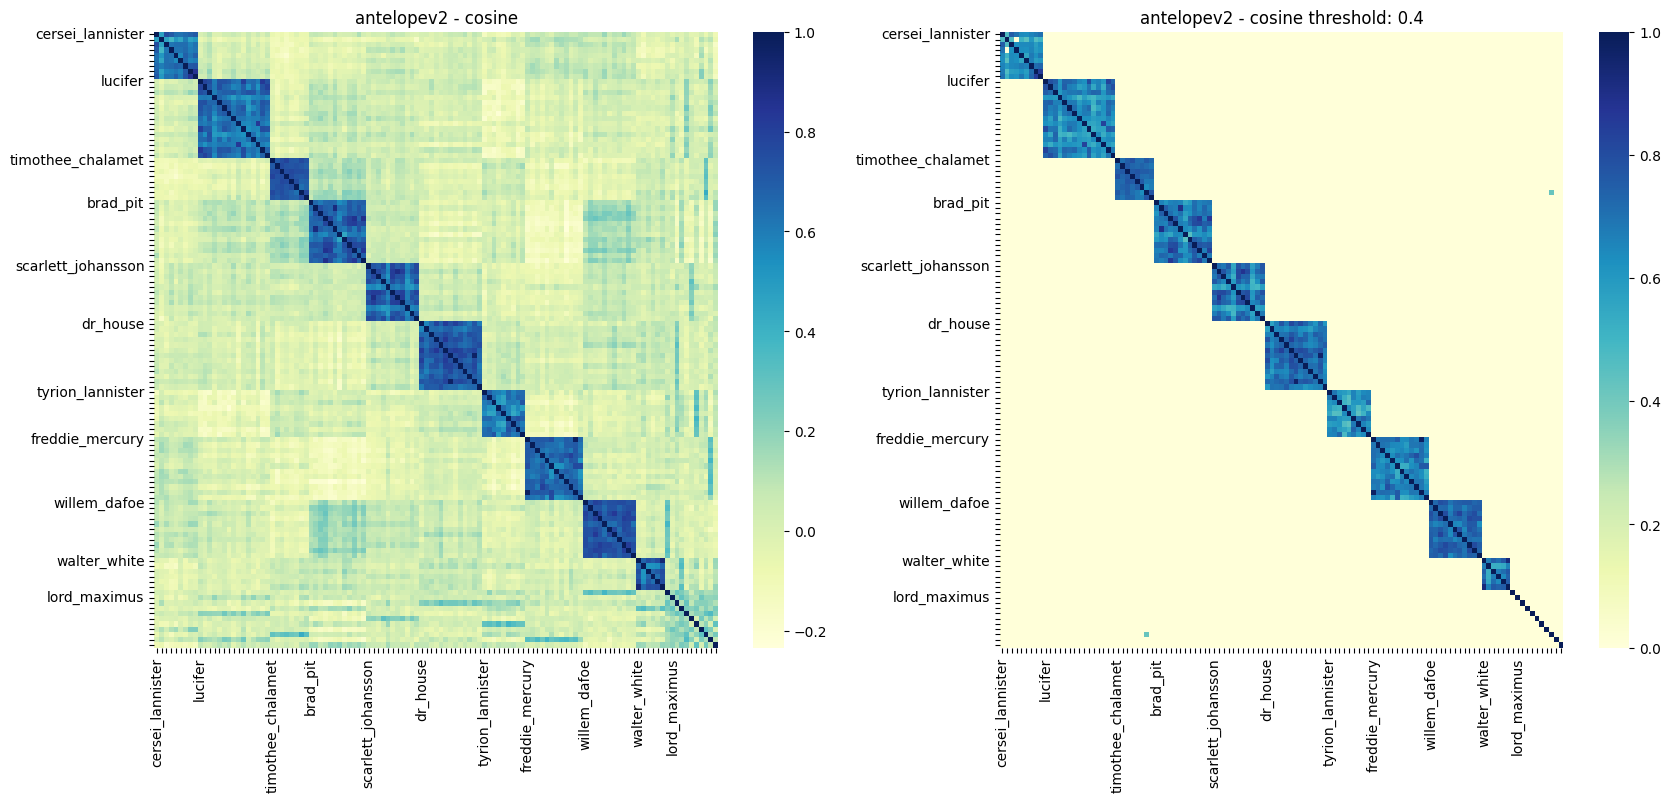

(117, 117)


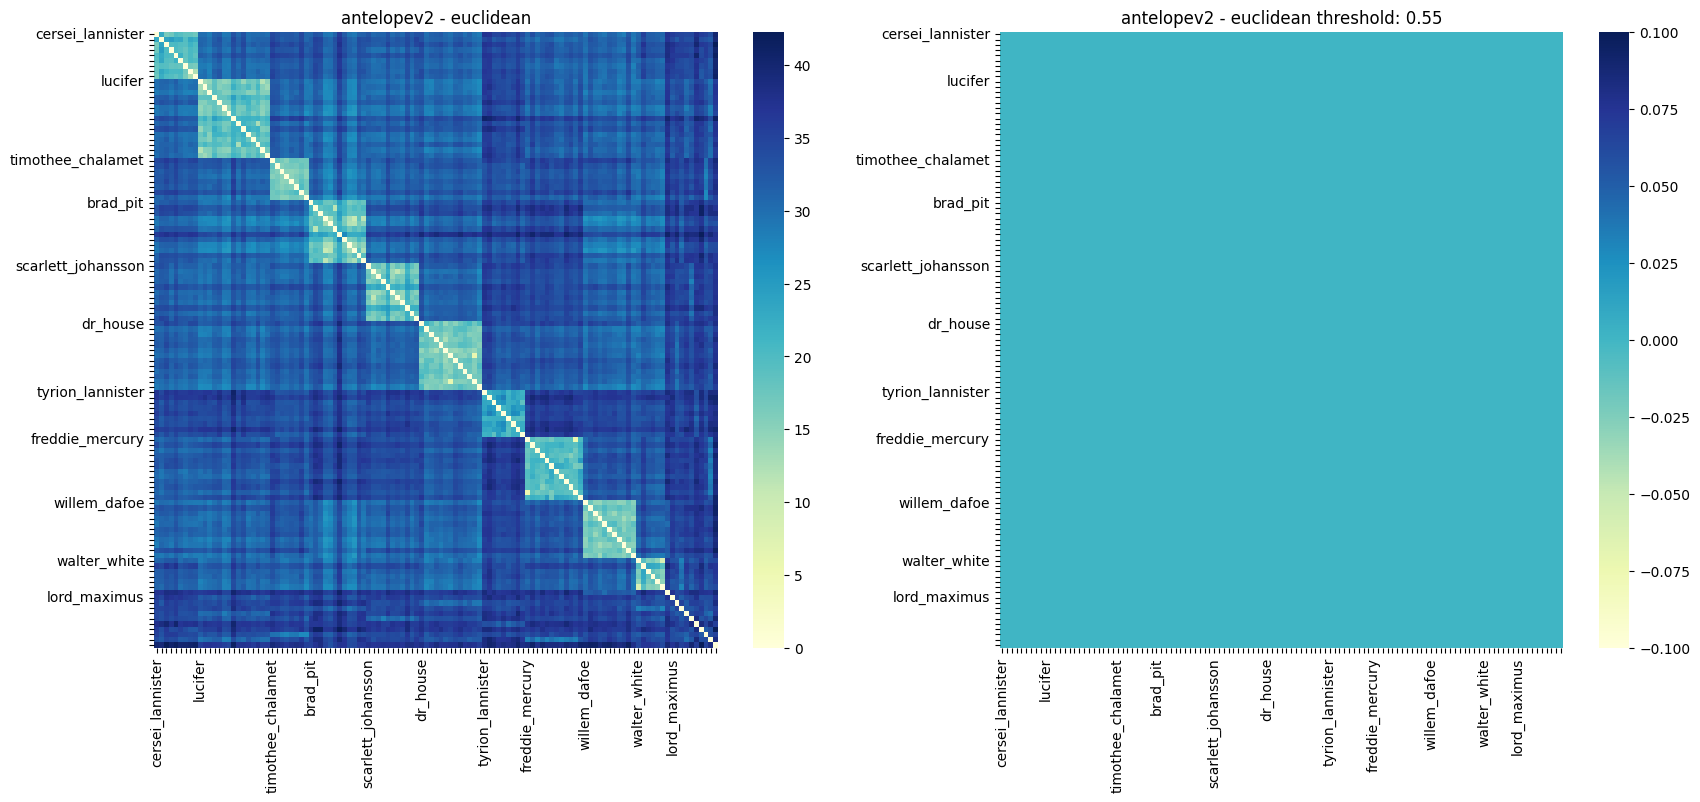

In [14]:
from deepface.commons.distance import findThreshold

# import cosine metric and euclidian metric from sklearn 
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances


for model_name, model_df in model2df.items():  
    print(model_name)
    X = np.array(model_df["embeddings"].values.tolist())
    print(X.shape)
    metric2distances = {}
    for metric_name, metric_fun in zip(["cosine", "euclidean"], [cosine_similarity, euclidean_distances]):
        distances = model_df["embeddings"].apply(lambda x: metric_fun(X, x.reshape(1, -1)))
        d = np.array(distances.values.tolist()).squeeze(-1)
        metric2distances[metric_name] = d
    
    labels = []
    for l in model_df["labels"]:
        if l not in labels:
            labels.append(l)
        else:
            labels.append("")
    
    # display heatmap for each metric
    for metric_name, d in metric2distances.items():
        fig, axs = plt.subplots(1, 2, figsize=(20, 8))
        sns.heatmap(
            d,
            xticklabels=labels,
            yticklabels=labels,
            cmap="YlGnBu",
            ax=axs[0]
        )
        axs[0].set_title(f"{model_name} - {metric_name}")

        thresh = findThreshold(model_name, metric_name)
        if metric_name == "cosine":
            d[d < thresh] = 0
        else:
            d[d > thresh] = 0

        print(d.shape)
        sns.heatmap(
            d,
            xticklabels=labels,
            yticklabels=labels,
            cmap="YlGnBu",
            ax=axs[1]
        )
        axs[1].set_title(f"{model_name} - {metric_name} threshold: {thresh}")
        plt.show()

# Map embeddings onto 2D plane

## t-SNE

In [15]:
from sklearn.manifold import TSNE

model2tsne = {}
for model, model_dict in embeddings.items():
    model_df = dict2df(model_dict)
    X = np.array(model_df["embeddings"].values.tolist())

    tsne = TSNE(n_components=2, random_state=0, perplexity=15, n_iter=2000, metric="cosine")
    embeddings_tsne = tsne.fit_transform(X)

    model2tsne[model] = embeddings_tsne

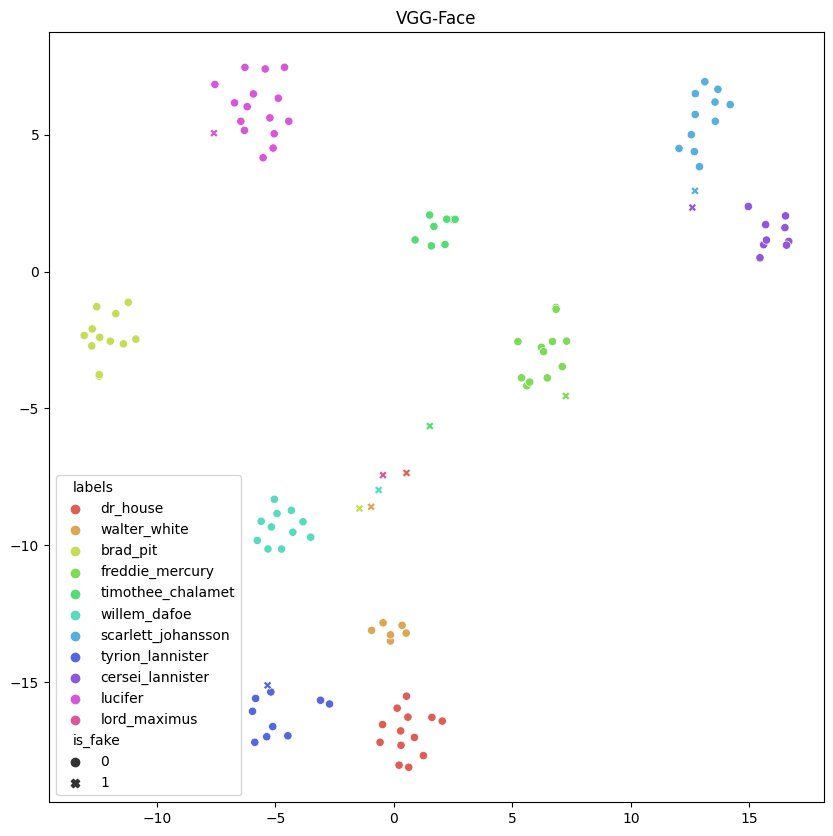

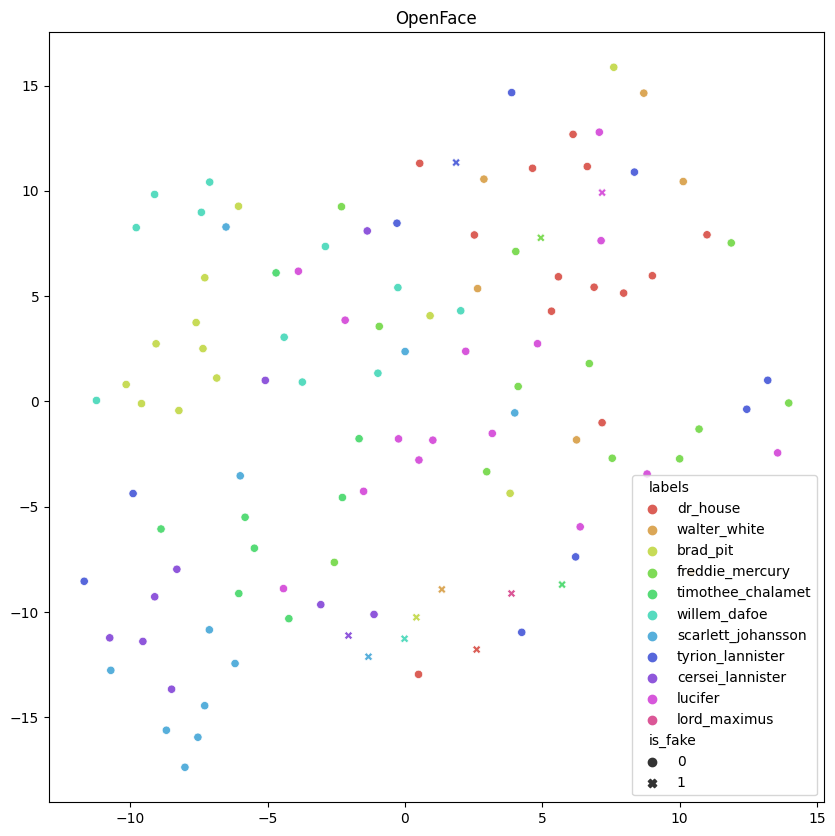

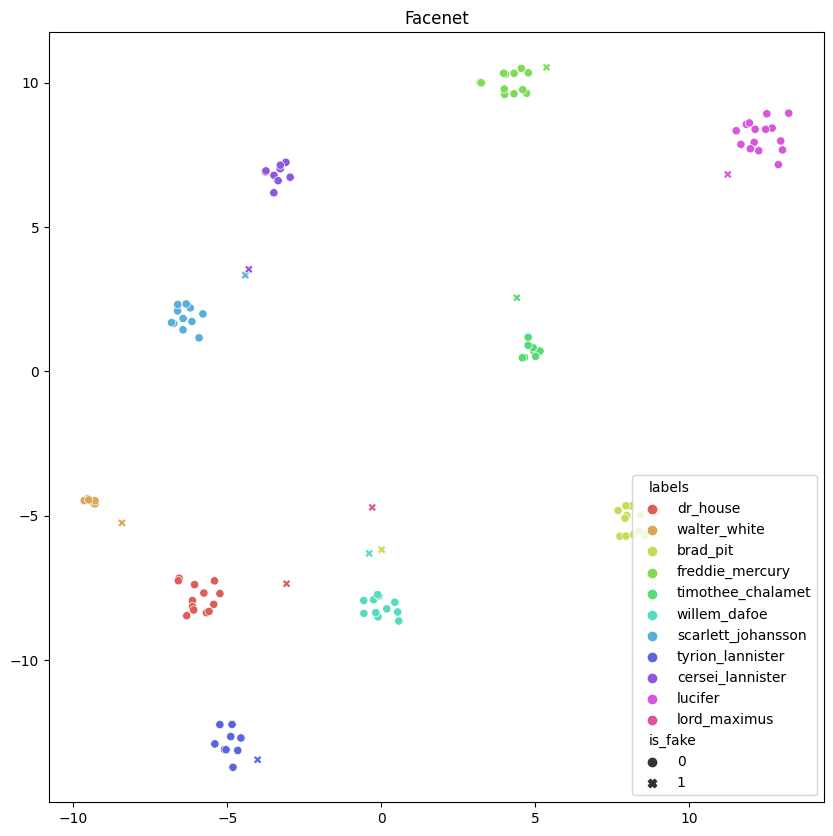

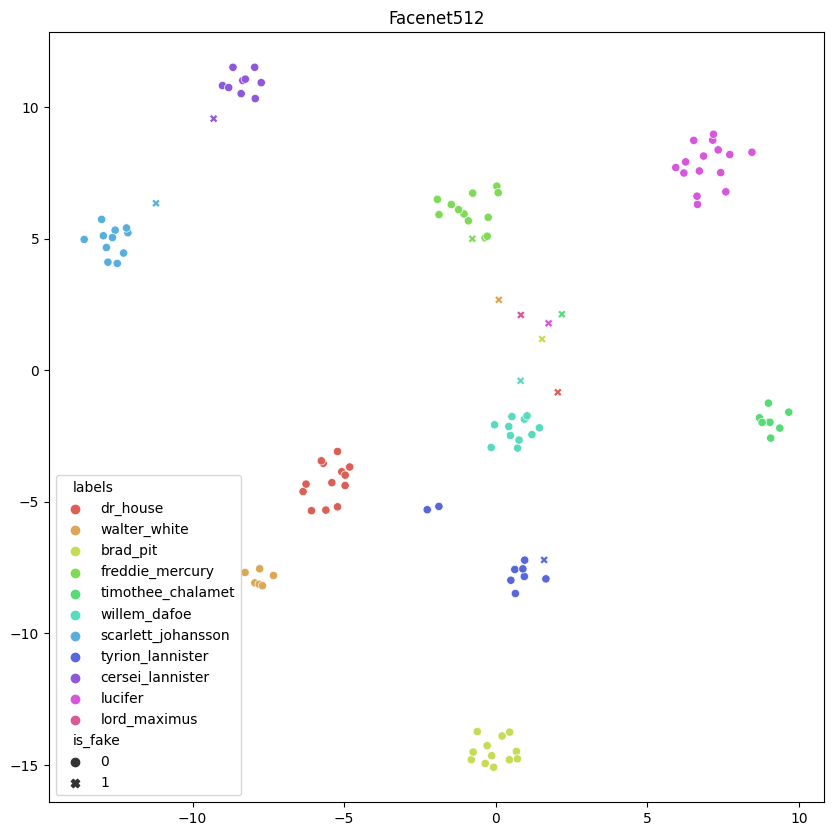

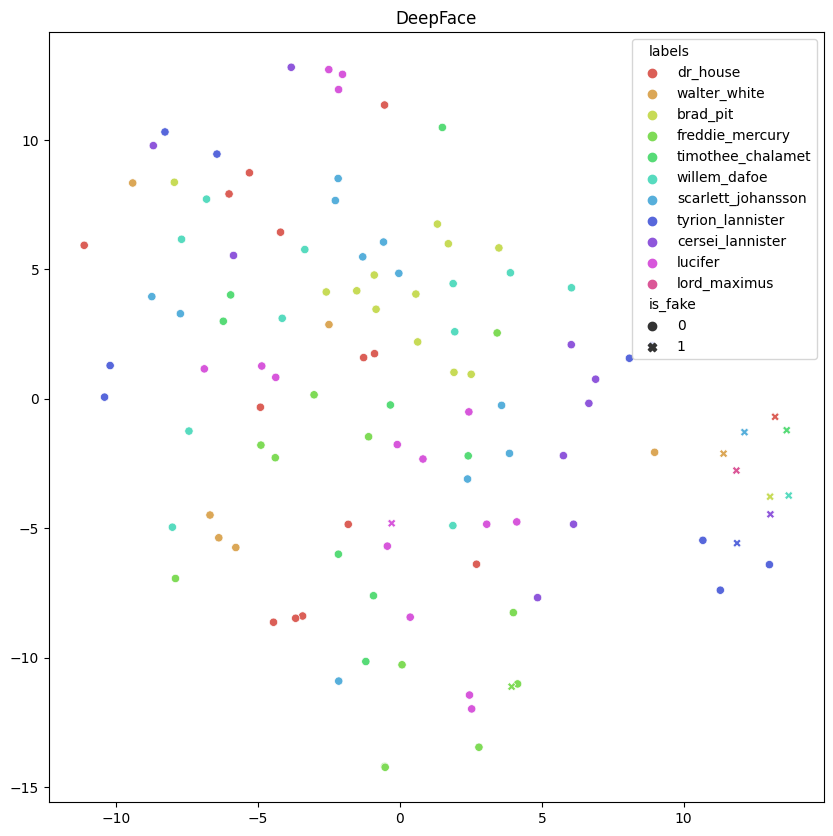

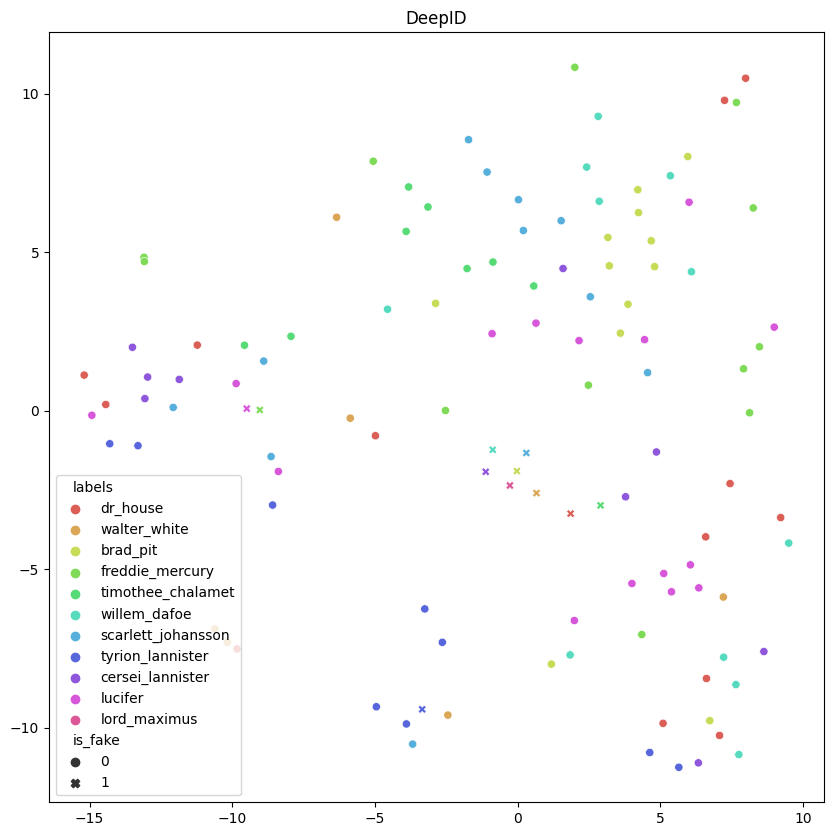

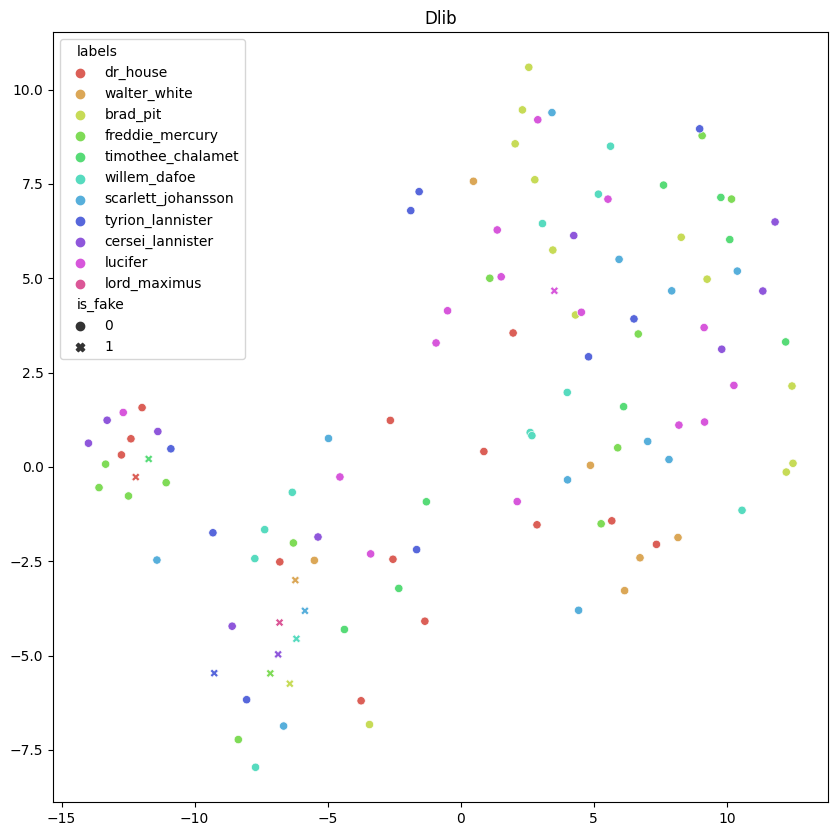

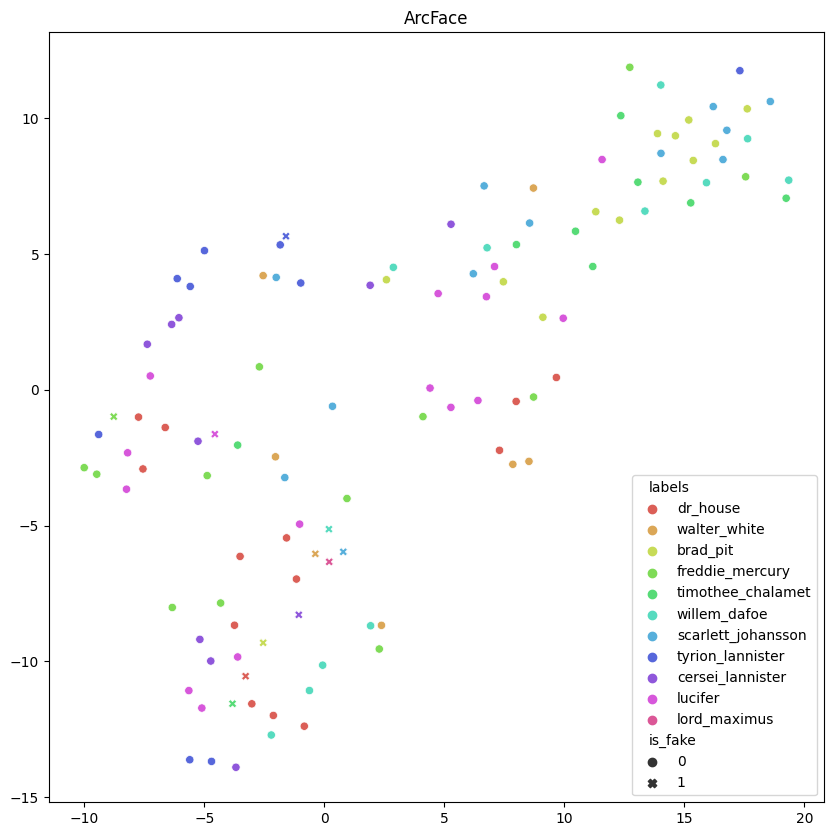

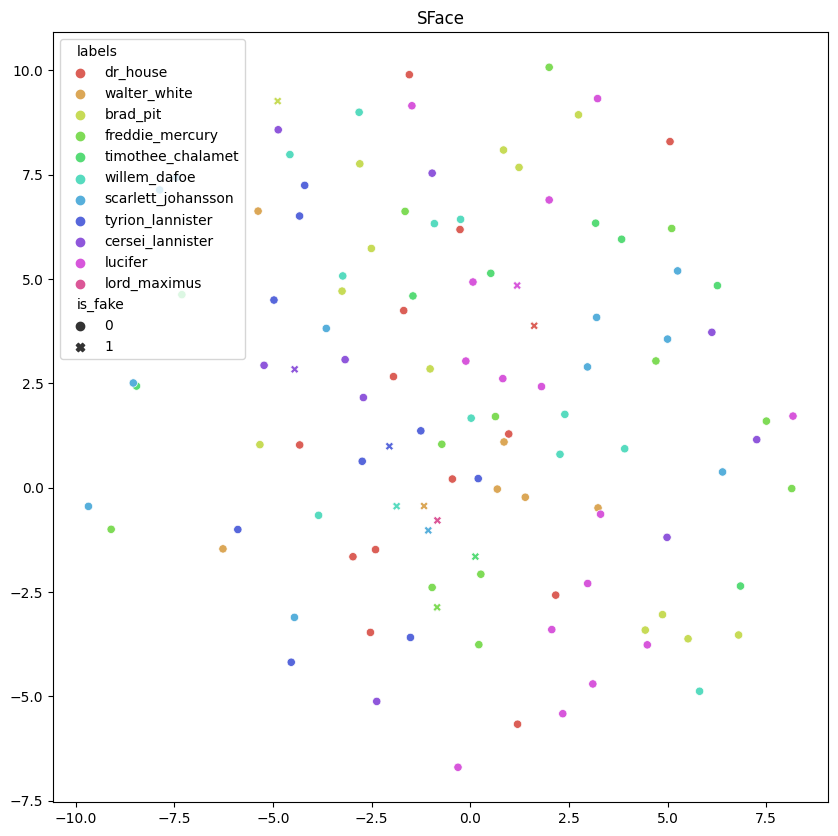

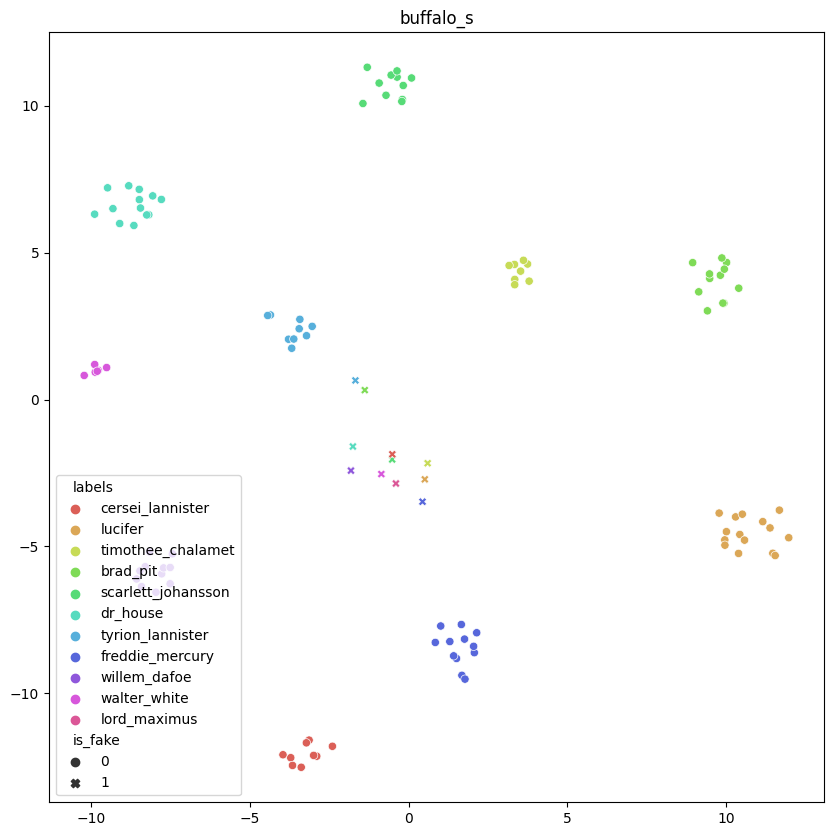

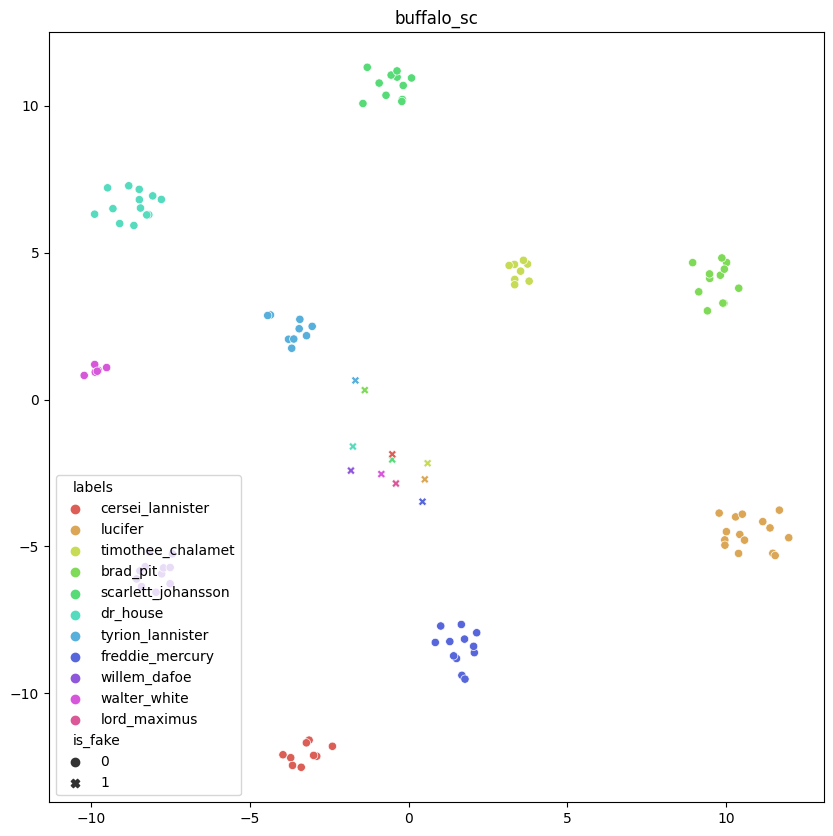

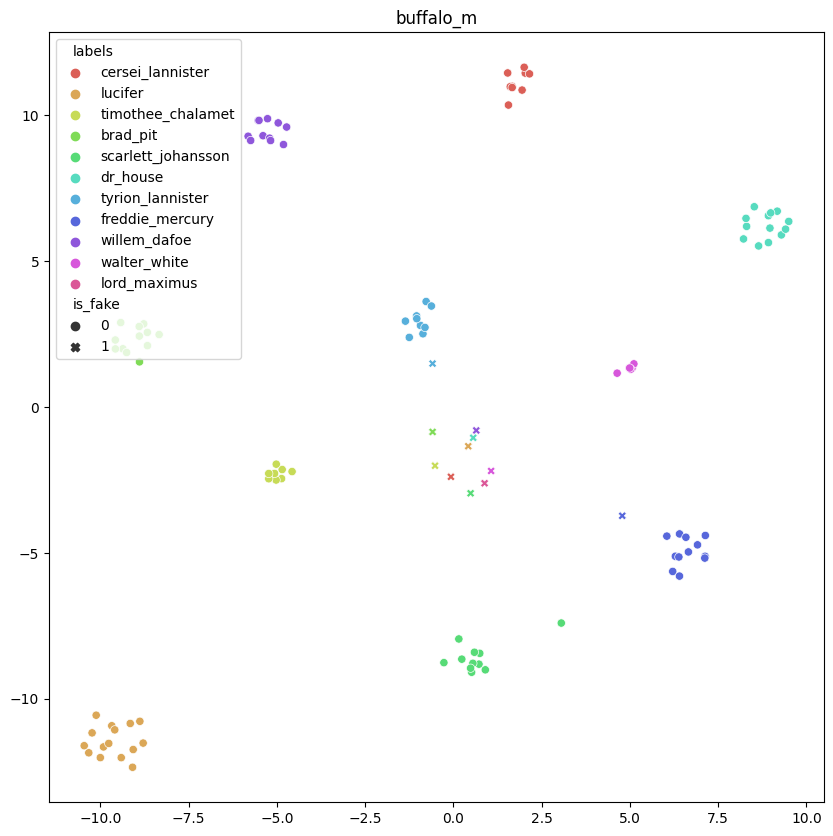

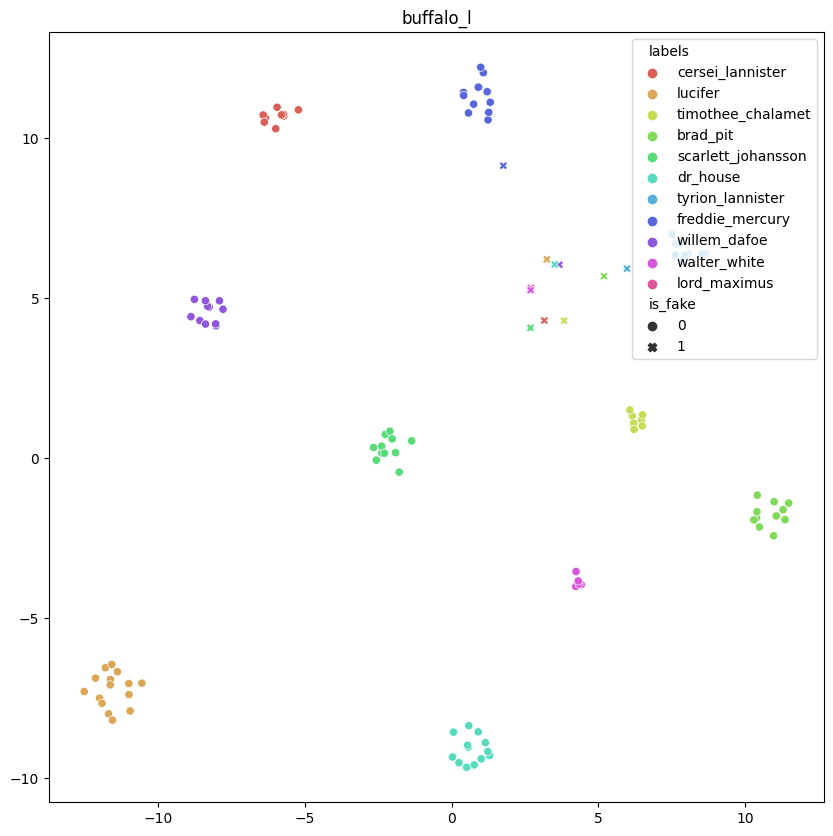

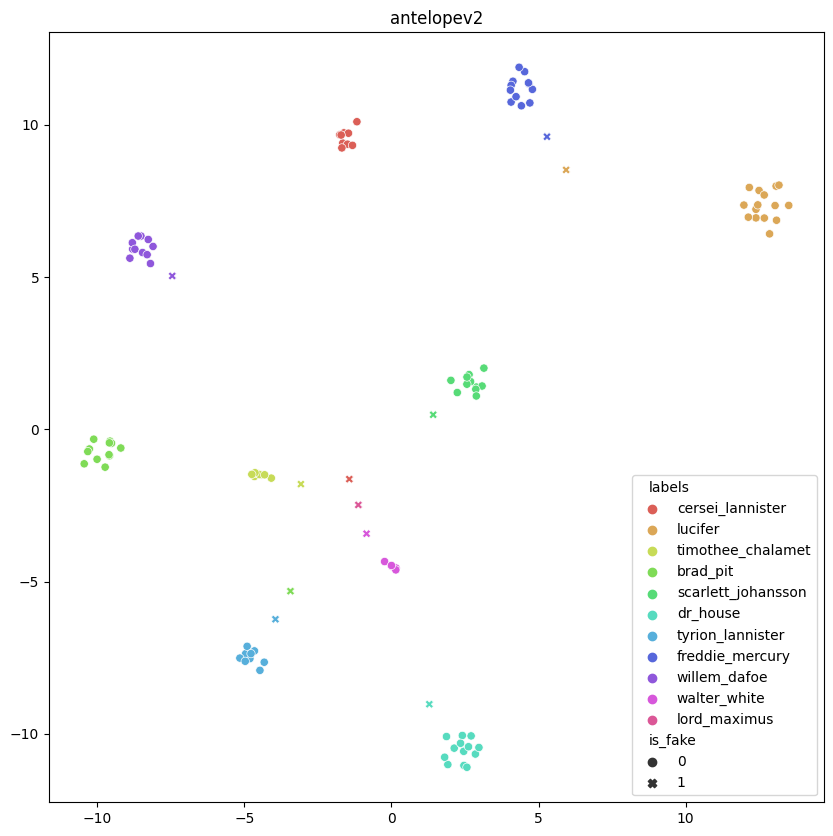

In [16]:
for model, tsne_mapping in model2tsne.items():
    plt.figure(figsize=(10, 10))
    sns.scatterplot(
        x=tsne_mapping[:,0], y=tsne_mapping[:,1],
        hue=model2df[model]["labels"],
        style=model2df[model]["is_fake"],
        palette=sns.color_palette("hls", len(model2df[model]["labels"].unique()))
    )
    plt.title(model)
    plt.show()

## UMAP

In [17]:
from umap import UMAP

model2umap= {}
for model, model_dict in embeddings.items():
    model_df = dict2df(model_dict)
    X = np.array(model_df["embeddings"].values.tolist())

    umap = UMAP(n_components=2, random_state=0, n_neighbors=5, min_dist=0.1, metric='cosine')
    embeddings_umap = umap.fit_transform(X)

    model2umap[model] = embeddings_umap
    

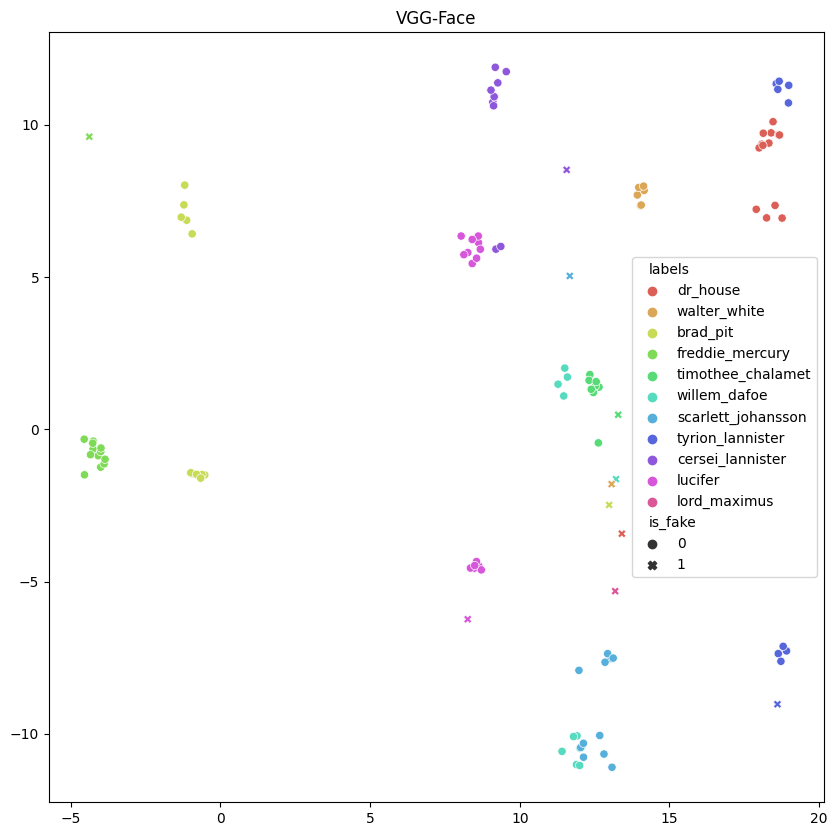

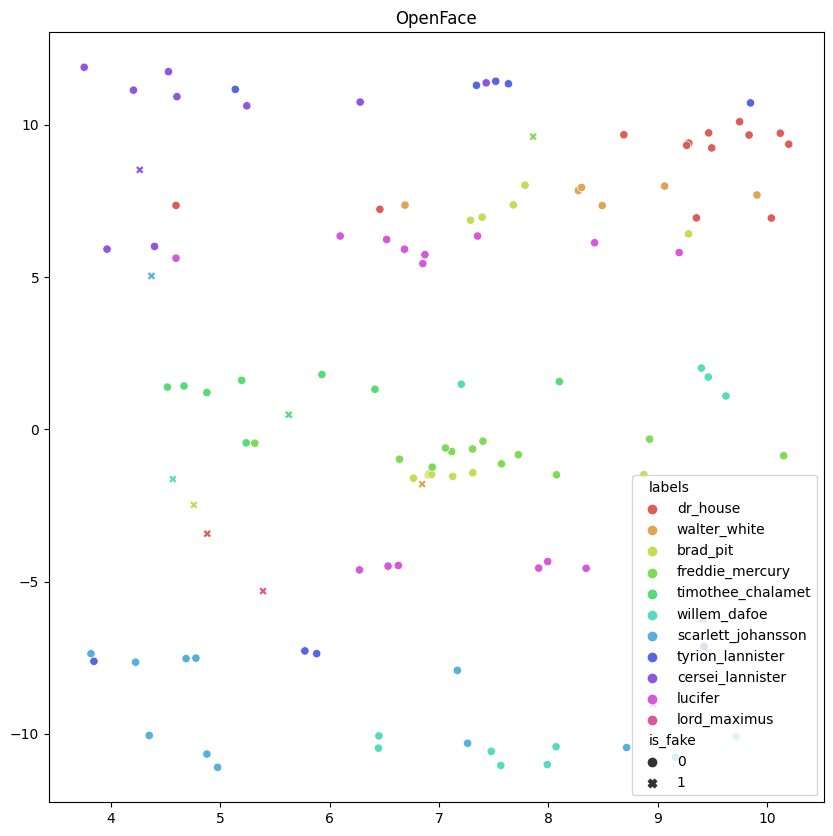

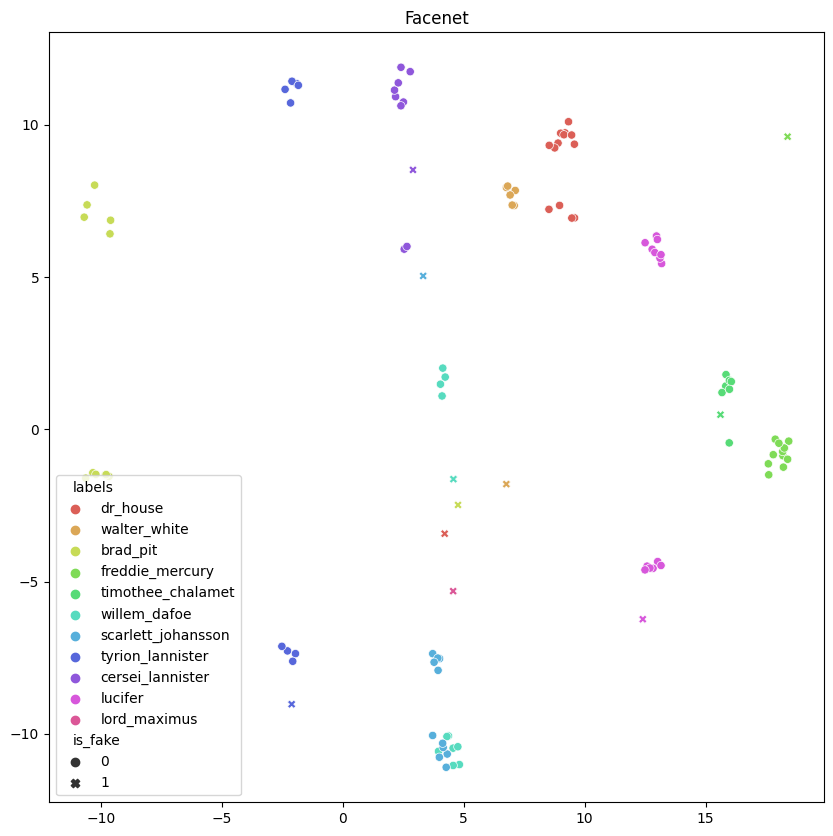

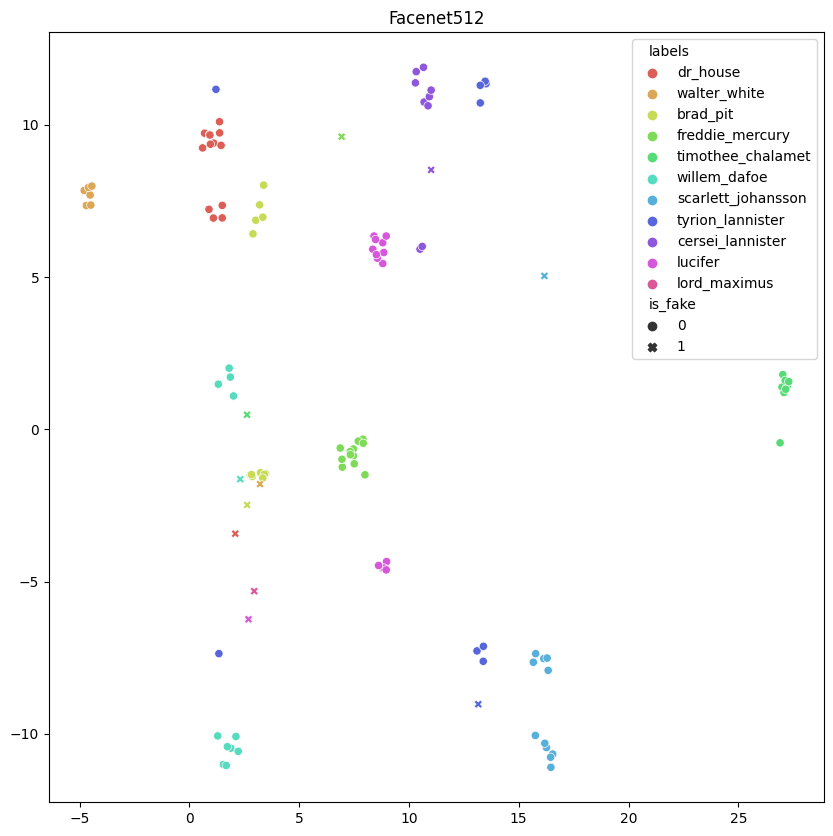

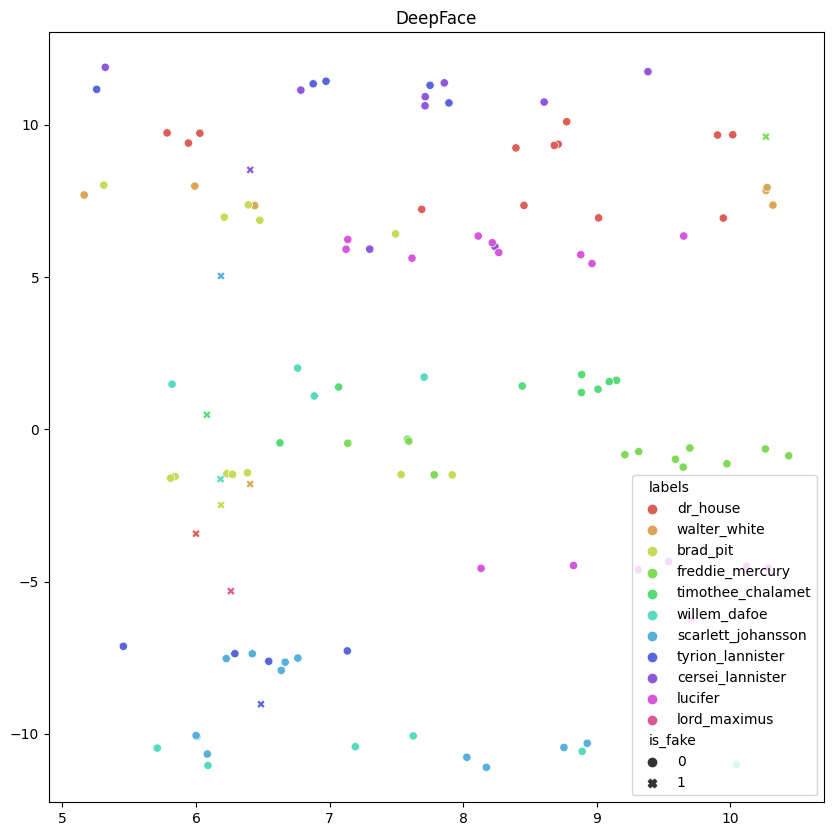

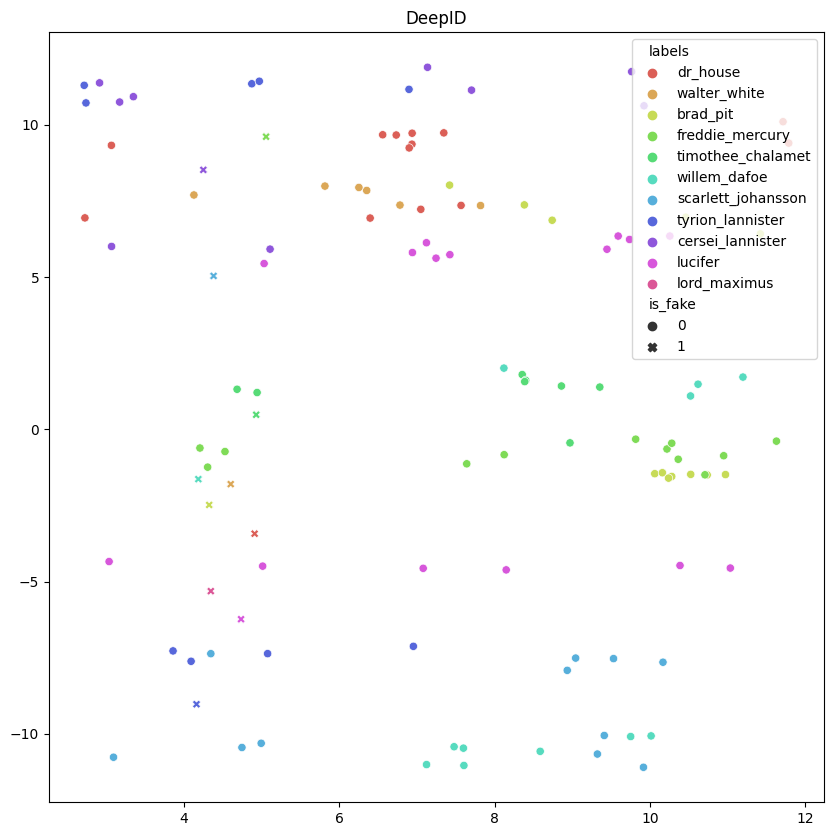

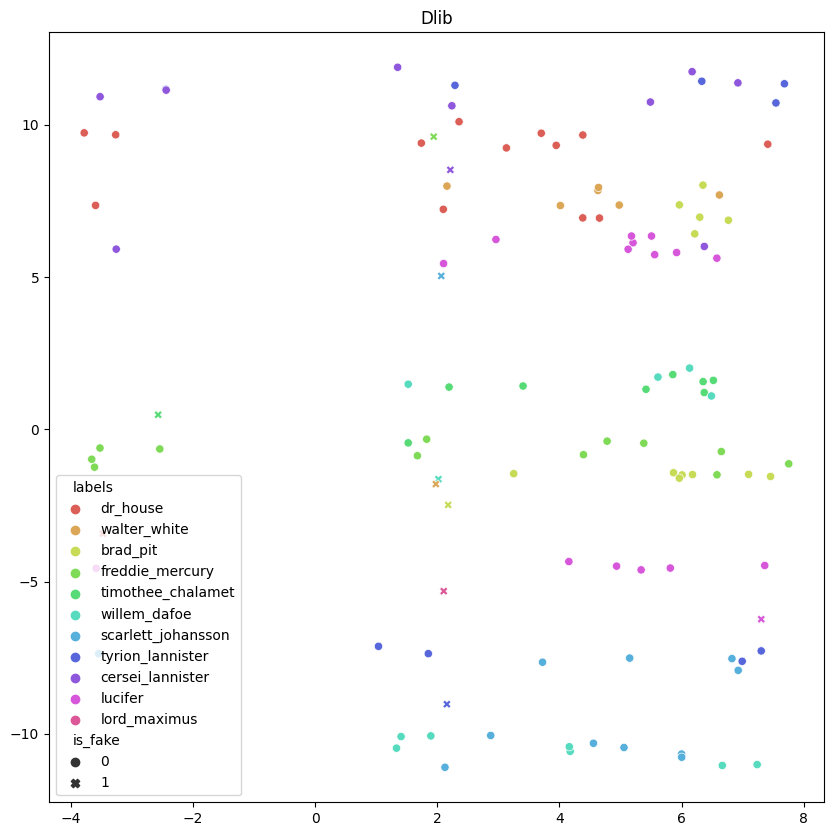

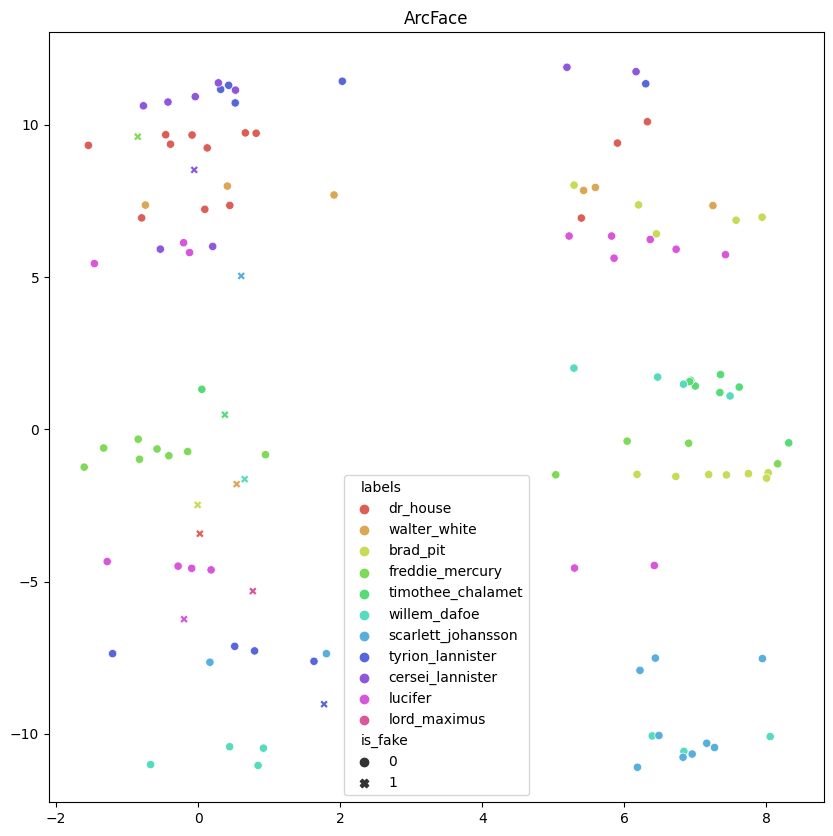

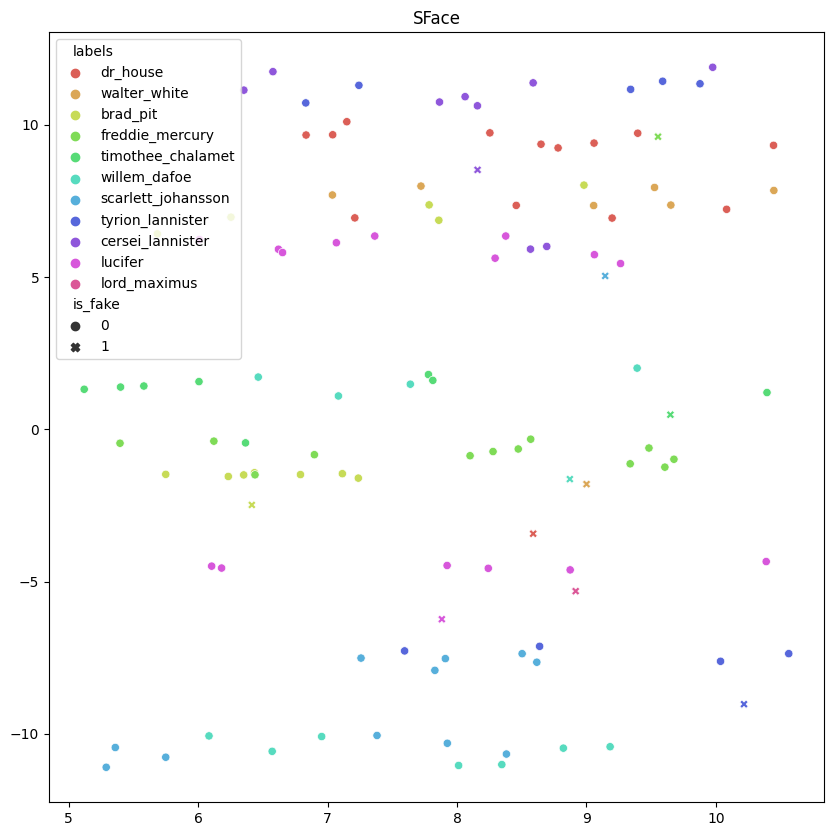

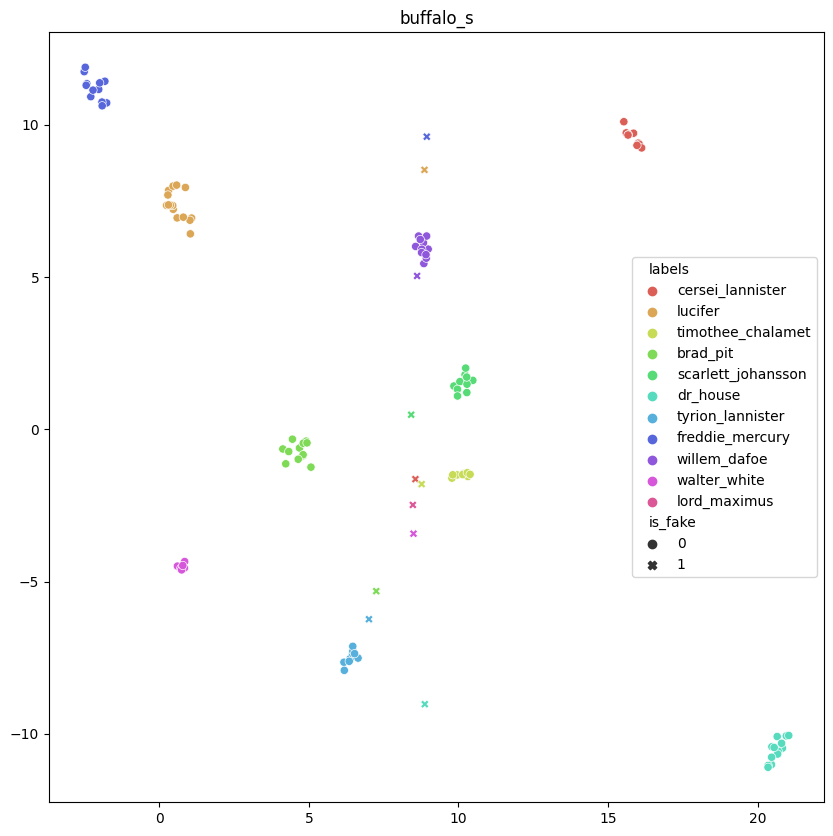

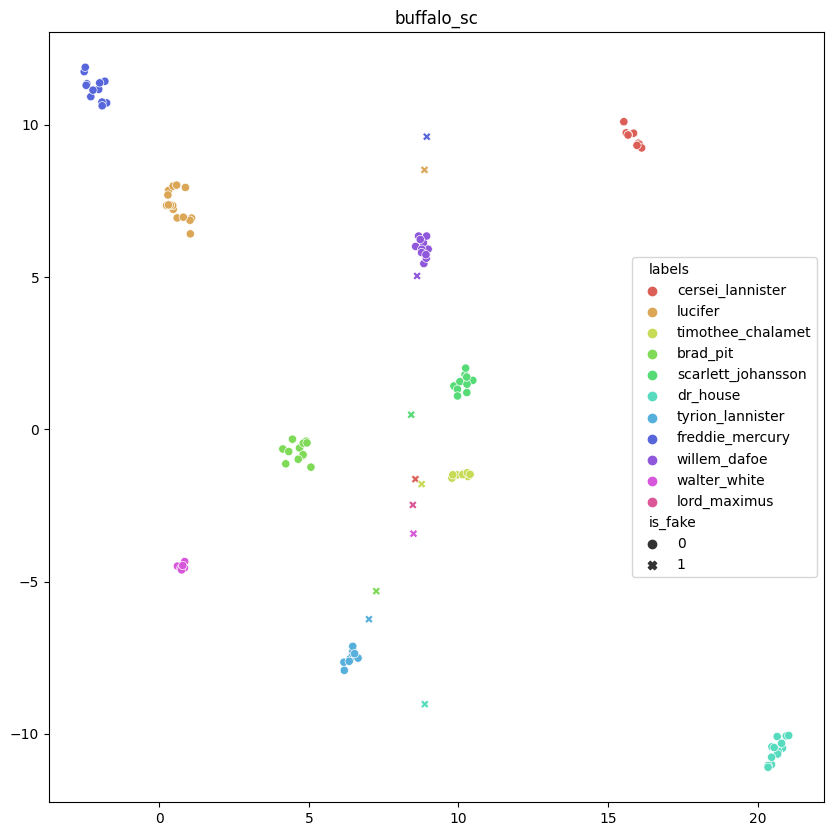

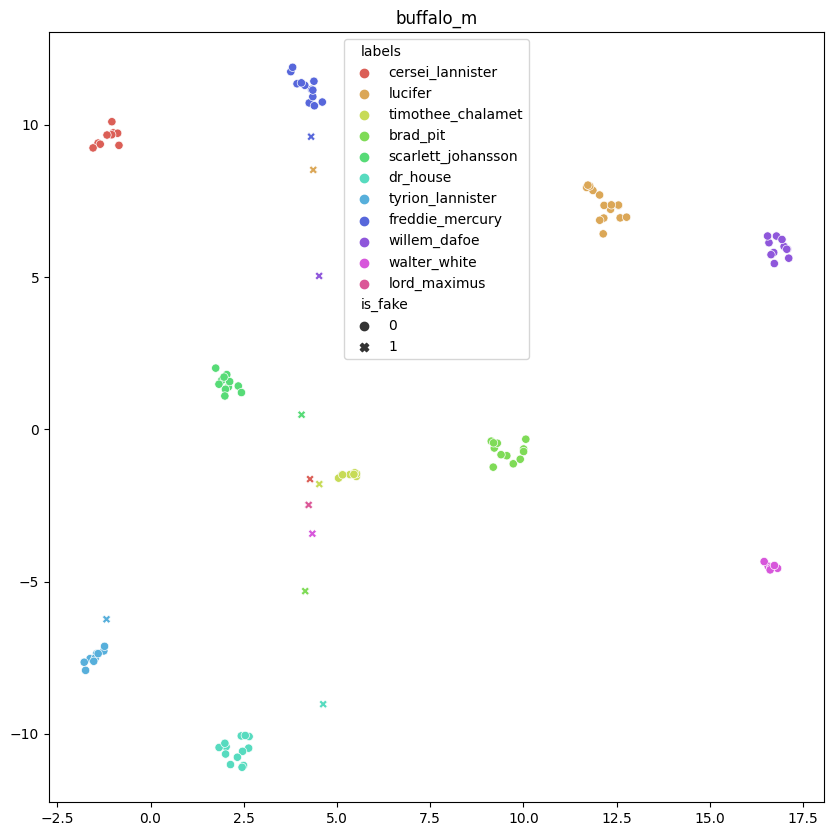

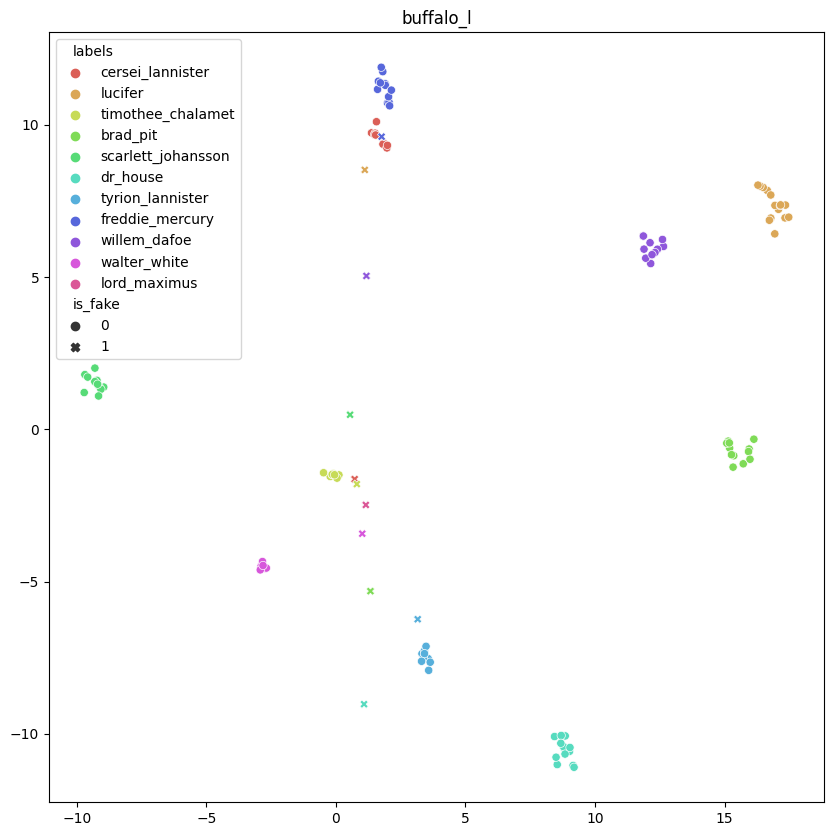

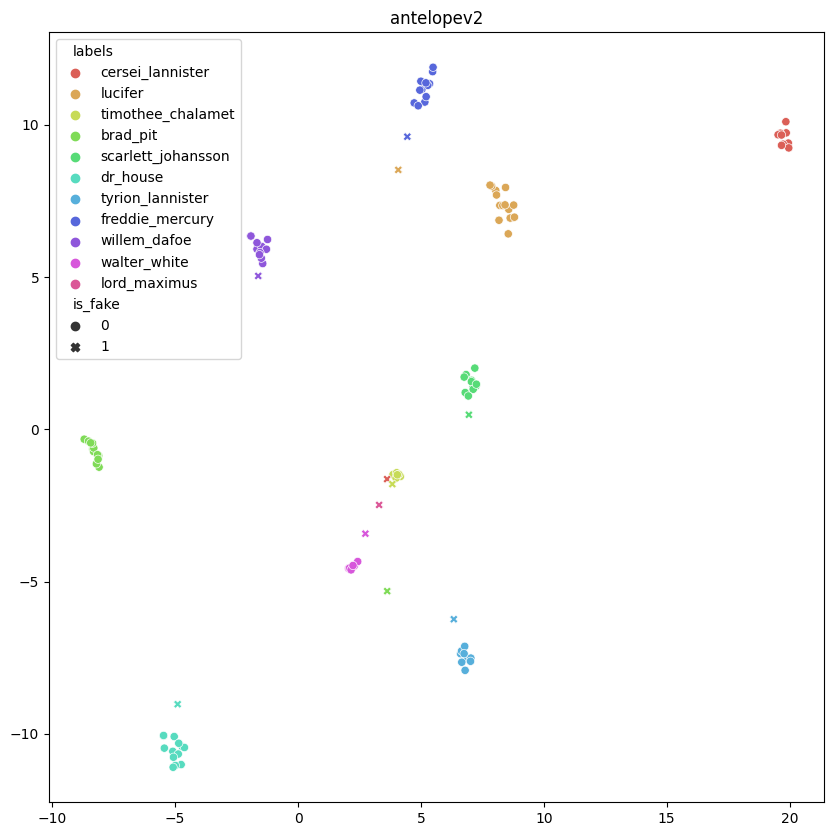

In [18]:
for model, umap_embedding in model2umap.items():
    plt.figure(figsize=(10, 10))
    sns.scatterplot(
        x=umap_embedding[:,0], y=tsne_mapping[:,1],
        hue=model2df[model]["labels"],
        style=model2df[model]["is_fake"],
        palette=sns.color_palette("hls", len(model2df[model]["labels"].unique()))
    )
    plt.title(model)
    plt.show()

# Feature selection

brad_pit


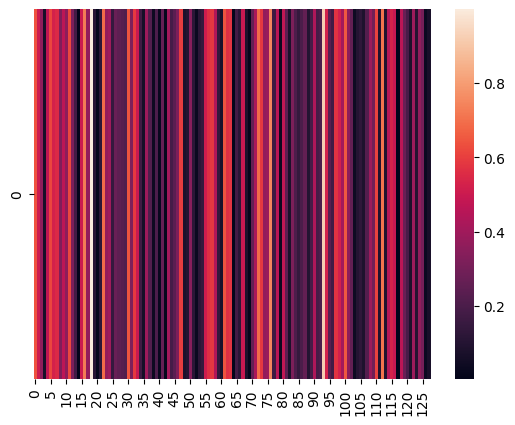

maximal variance for feature  105  is  0.16582558455392277

cersei_lannister


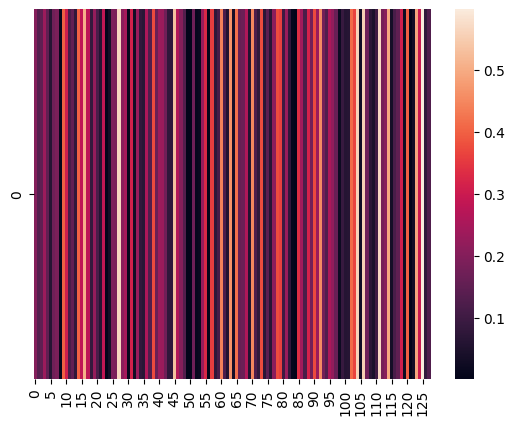

maximal variance for feature  4  is  0.22536376422158305

dr_house


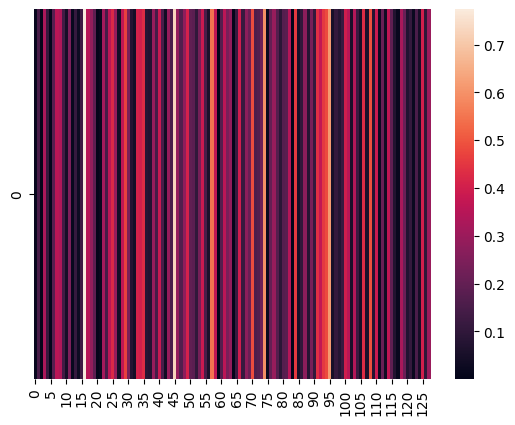

maximal variance for feature  13  is  0.209763770971603

freddie_mercury


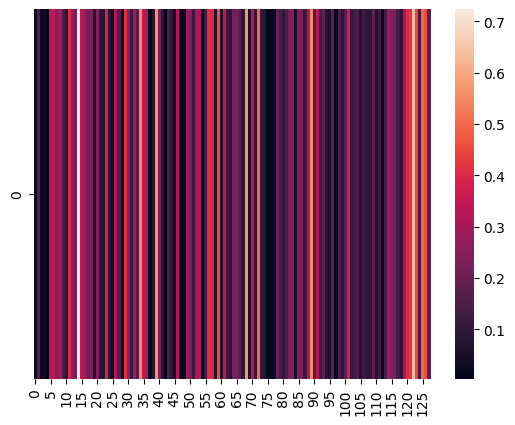

maximal variance for feature  16  is  0.28997499380946484

lord_maximus


/var/folders/j2/83k2pfk133n_vkpjy9xj72c00000gn/T/ipykernel_1009/3791674607.py:5: RuntimeWarning: Mean of empty slice.
  diff = abs(X_real.mean(axis=0) - x_fake)
/Users/czyjtu/dev/MP2023/venv/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/czyjtu/dev/MP2023/venv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/czyjtu/dev/MP2023/venv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


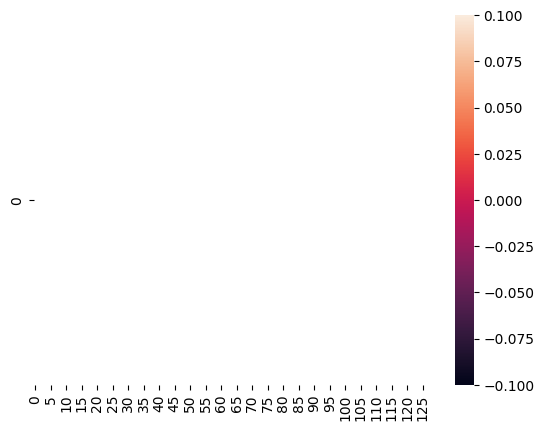

maximal variance for feature  0  is  nan

lucifer


/var/folders/j2/83k2pfk133n_vkpjy9xj72c00000gn/T/ipykernel_1009/3791674607.py:8: RuntimeWarning: Degrees of freedom <= 0 for slice
  print("maximal variance for feature ", X_real.var(axis=0).argmax(), " is ", X_real.var(axis=0).max())
/Users/czyjtu/dev/MP2023/venv/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/czyjtu/dev/MP2023/venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


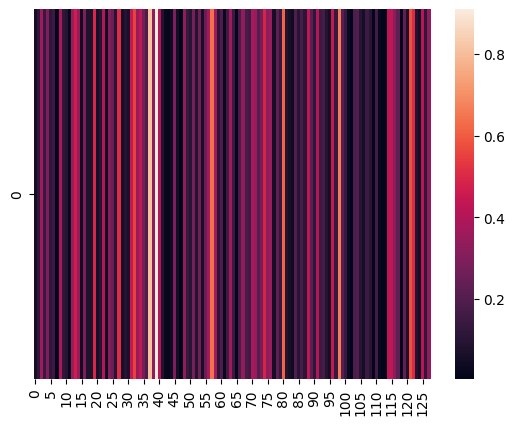

maximal variance for feature  48  is  0.2701299666902158

scarlett_johansson


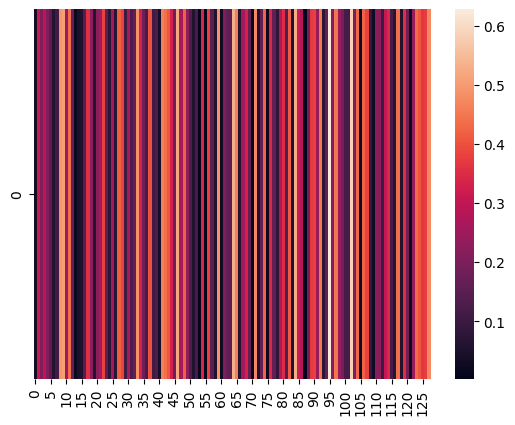

maximal variance for feature  116  is  0.29688112699354174

timothee_chalamet


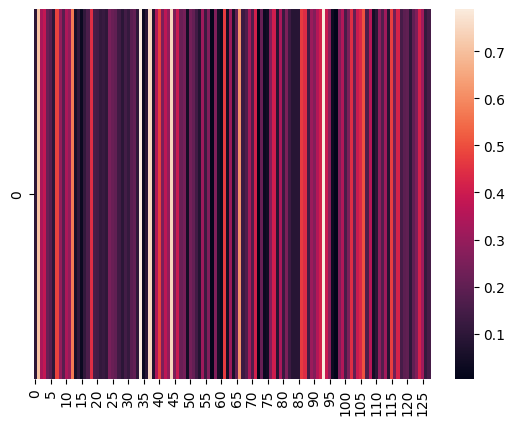

maximal variance for feature  83  is  0.2569035505069792

tyrion_lannister


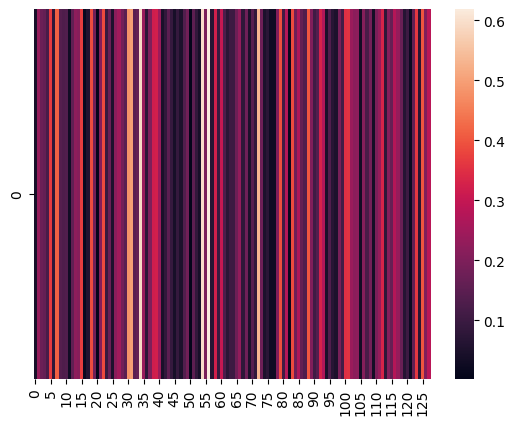

maximal variance for feature  47  is  0.24786652331722583

walter_white


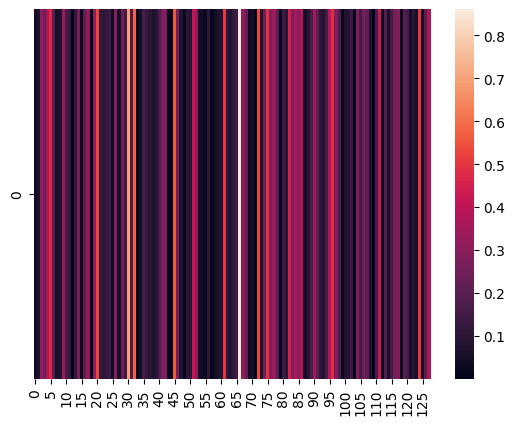

maximal variance for feature  9  is  0.2571076357604006

willem_dafoe


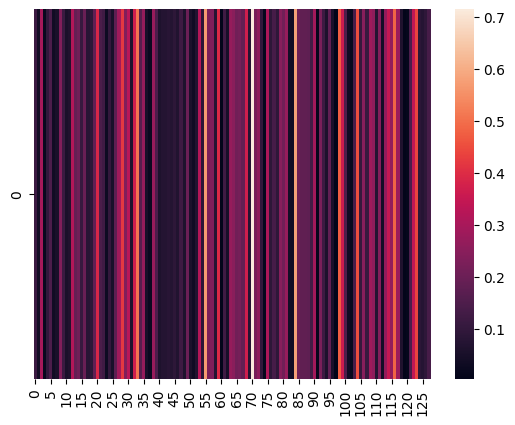

maximal variance for feature  37  is  0.18424487122411826



In [19]:
for label, features in model2df["SFace"].groupby("labels"):
    print(label)
    X_real = np.array(features[features["is_fake"] == 0]["embeddings"].values.tolist())
    x_fake = np.array(features[features["is_fake"] == 1]["embeddings"].values.tolist())[0] # only one fake image per label
    diff = abs(X_real.mean(axis=0) - x_fake)
    sns.heatmap(diff.reshape(1, -1))
    plt.show()
    print("maximal variance for feature ", X_real.var(axis=0).argmax(), " is ", X_real.var(axis=0).max()) 
    print()